# **Time Series Analysis of Doubleknit Fabric Demand**

### Full Report
Please find the [Full Report HERE]()

---
This project analyzes historical demand data for doubleknit fabric to develop an accurate forecasting model. The analysis follows a comprehensive time series methodology to identify patterns, seasonality, and trends in the demand data. The dataset is taken from an [Open Time Series Dataset](https://www.kaggle.com/datasets/krish525/open-time-series-data) in [Kaggle](https://www.kaggle.com)

---

### Methodology
The analysis includes:
- Exploratory data analysis and visualization
- Time series decomposition to identify trend, seasonal, and irregular components
- Stationarity assessment using ADF and KPSS tests
- Data transformation using Box-Cox methods to stabilize variance
- Model selection through AIC, BIC, and residual analysis
- Comparison of various ARIMA models on out-of-sample data
- Diagnostic checking of residuals for model validation

---

### Objective
The ultimate goal is to develop a reliable forecasting model that can predict doubleknit fabric demand for the next 24 months, supporting production planning, inventory management, and business decision-making.

---

### Side Note
This project was the fruit of many test in many datasets tested to find a good demonstration of what we've studied so far, refer to [My GitHub Repository](https://github.com/LyesHADJAR/TSAC-Individual-Project) for the other TSA with different datasets.

---

## **Phase I: Identification**

In [1]:
# Link to the dataset below:
link <- "https://raw.githubusercontent.com/LyesHADJAR/TSAC-Individual-Project/refs/heads/main/data/Demand%20for%20a%20doubleknit%20fabric%20p269%20Montgomery%20Fore%20TS.csv"

In [4]:
# Install required packages if needed
# You can uncomment the install.packages line
# above if you need to install the packages

install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
                  "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
                  "FinTS", "ggthemes"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘rbibutils’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘leaps’, ‘locfit’, ‘quadprog’, ‘quantmod’, ‘Kendall’, ‘mvtnorm’, ‘Rdpack’




In [7]:
# Load required libraries and setup plot theme & settings

library(ggplot2)
library(forecast)
library(tseries)
library(dplyr)
library(lubridate)
library(gridExtra)
library(MASS)
library(knitr)
library(lawstat)
library(FinTS)
library(TSA)

options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}

### ***Data Preparation***

In [8]:
# loading the dataset
# checking for missing values
# and displaying the summary of the dataset
# create a data frame

data <- read.csv(link, header = TRUE)
summary(data)

missing_values <- sum(is.na(data))
if (missing_values > 0) {
  cat("There are", missing_values, "missing values in the dataset.\n")
} else {
  cat("There are no missing values in the dataset.\n")
}
head(data)

stats <- data %>%
  summarise(
    mean = mean(x),
    median = median(x),
    sd = sd(x),
    min = min(x),
    max = max(x)
  )
print(stats)

fabric_ts_df <- data %>%
  mutate(
    week = seq(1, nrow(data)),
    x = as.numeric(x),
  )

      week              x        
 Min.   :  1.00   Min.   :467.0  
 1st Qu.: 60.75   1st Qu.:560.8  
 Median :120.50   Median :600.0  
 Mean   :120.50   Mean   :591.6  
 3rd Qu.:180.25   3rd Qu.:625.5  
 Max.   :240.00   Max.   :704.0  

There are no missing values in the dataset.


,week,x
,<int>,<int>
1,1,656
2,2,659
3,3,601
4,4,624
5,5,545
6,6,502


      mean median       sd min max
1 591.5833    600 49.39341 467 704


### ***Data Visualization***

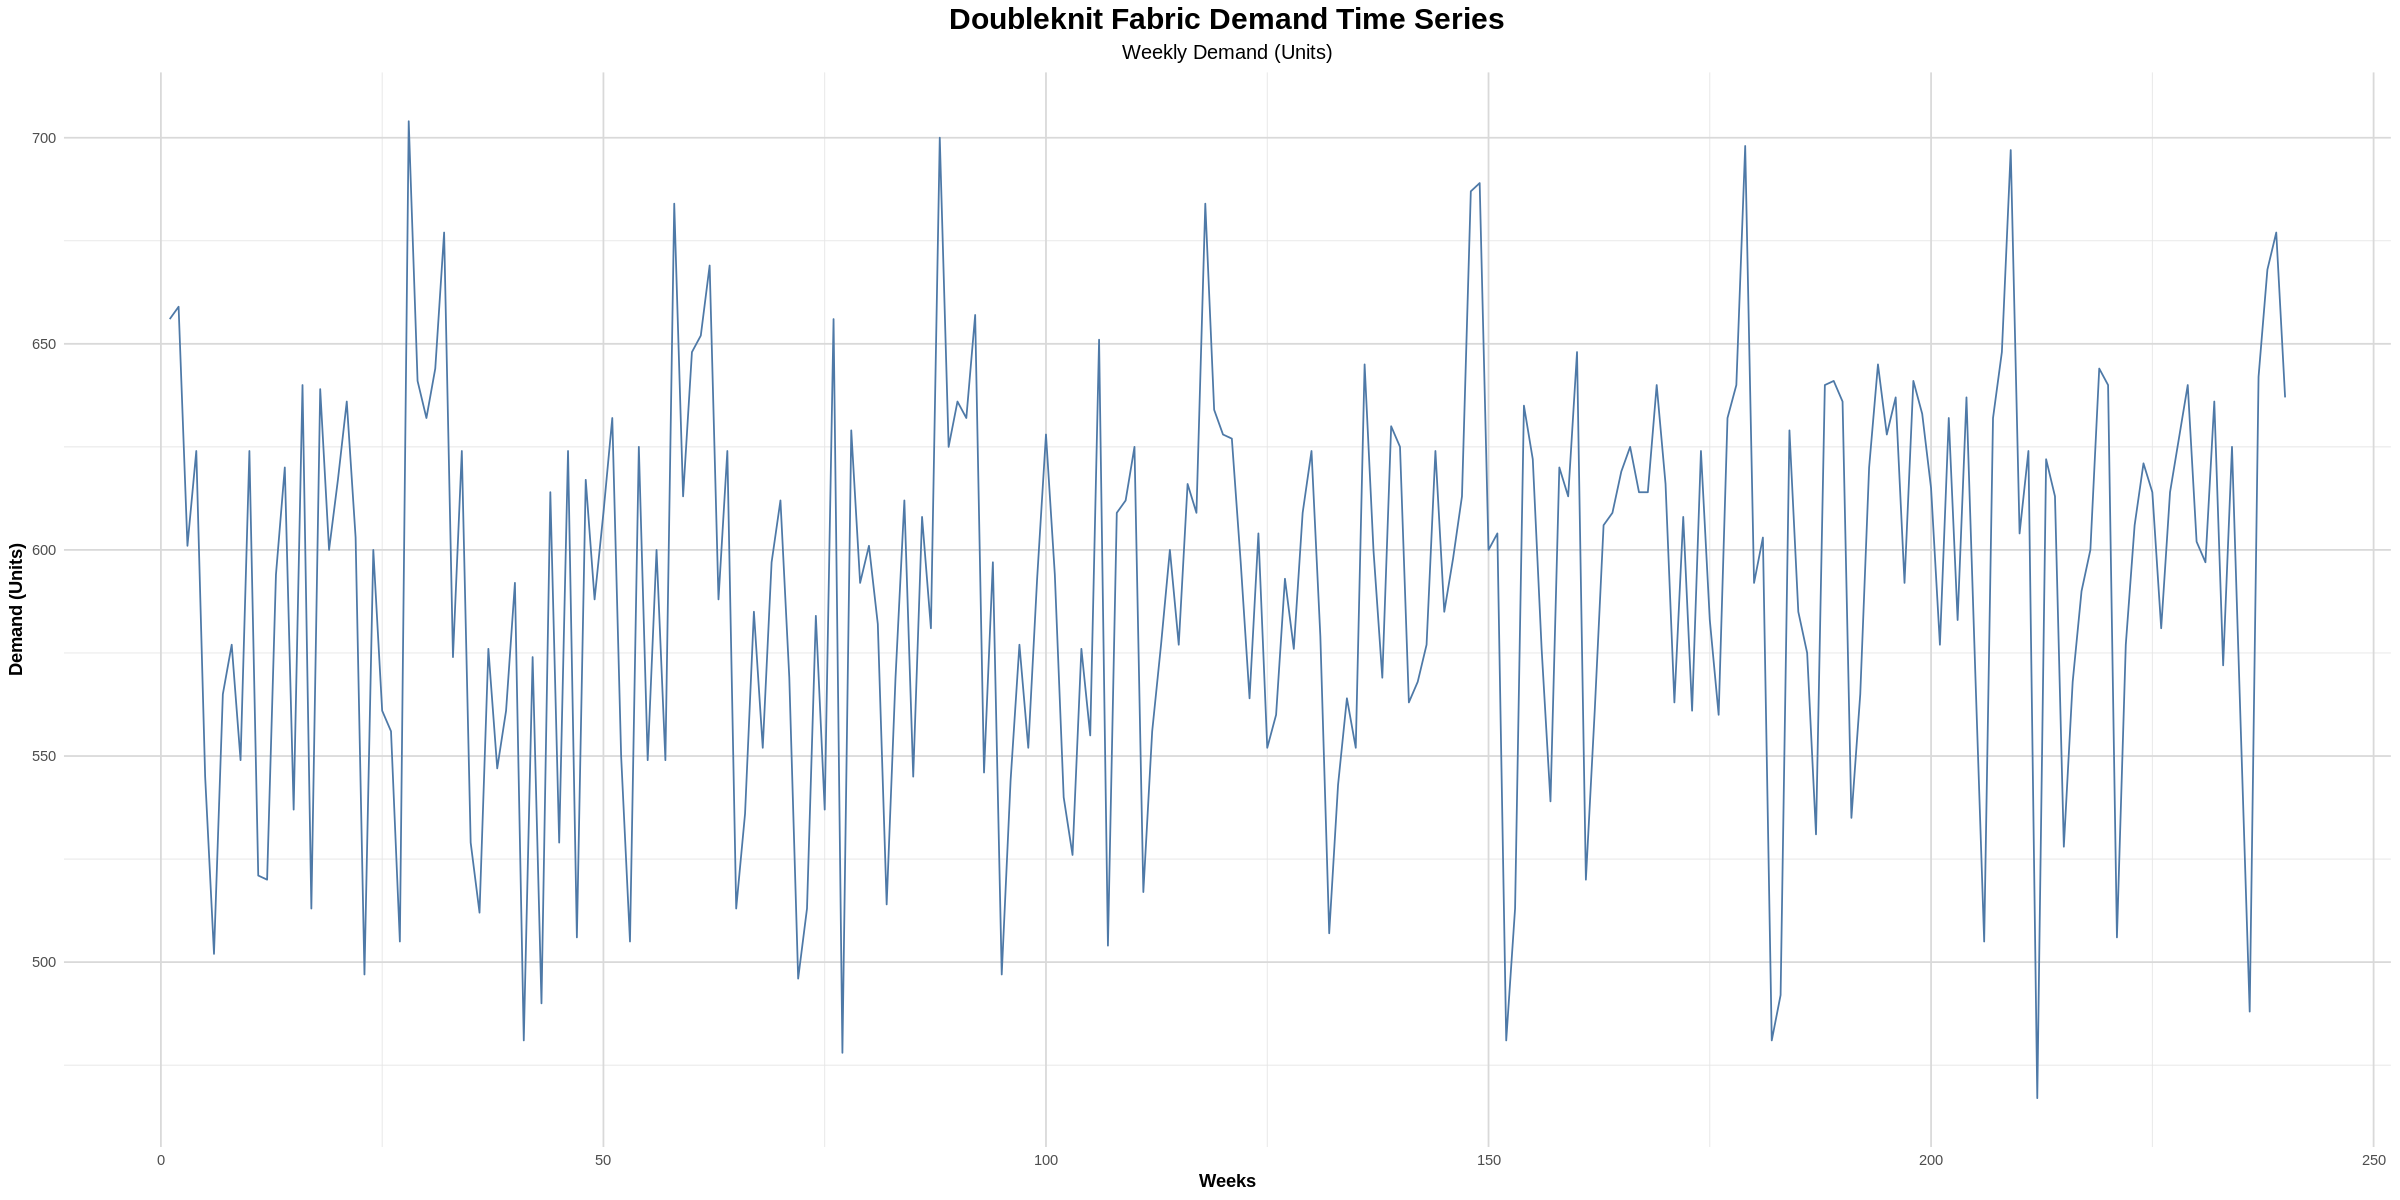

In [9]:
# plotting the series

p1 <- ggplot(fabric_ts_df, aes(x = week, y = x)) +
  geom_line(color = "#4E79A7") +
  labs(
    title = "Doubleknit Fabric Demand Time Series",
    subtitle = "Weekly Demand (Units)",
    x = "Weeks",
    y = "Demand (Units)"
  ) +
  theme_tsa()

print(p1)

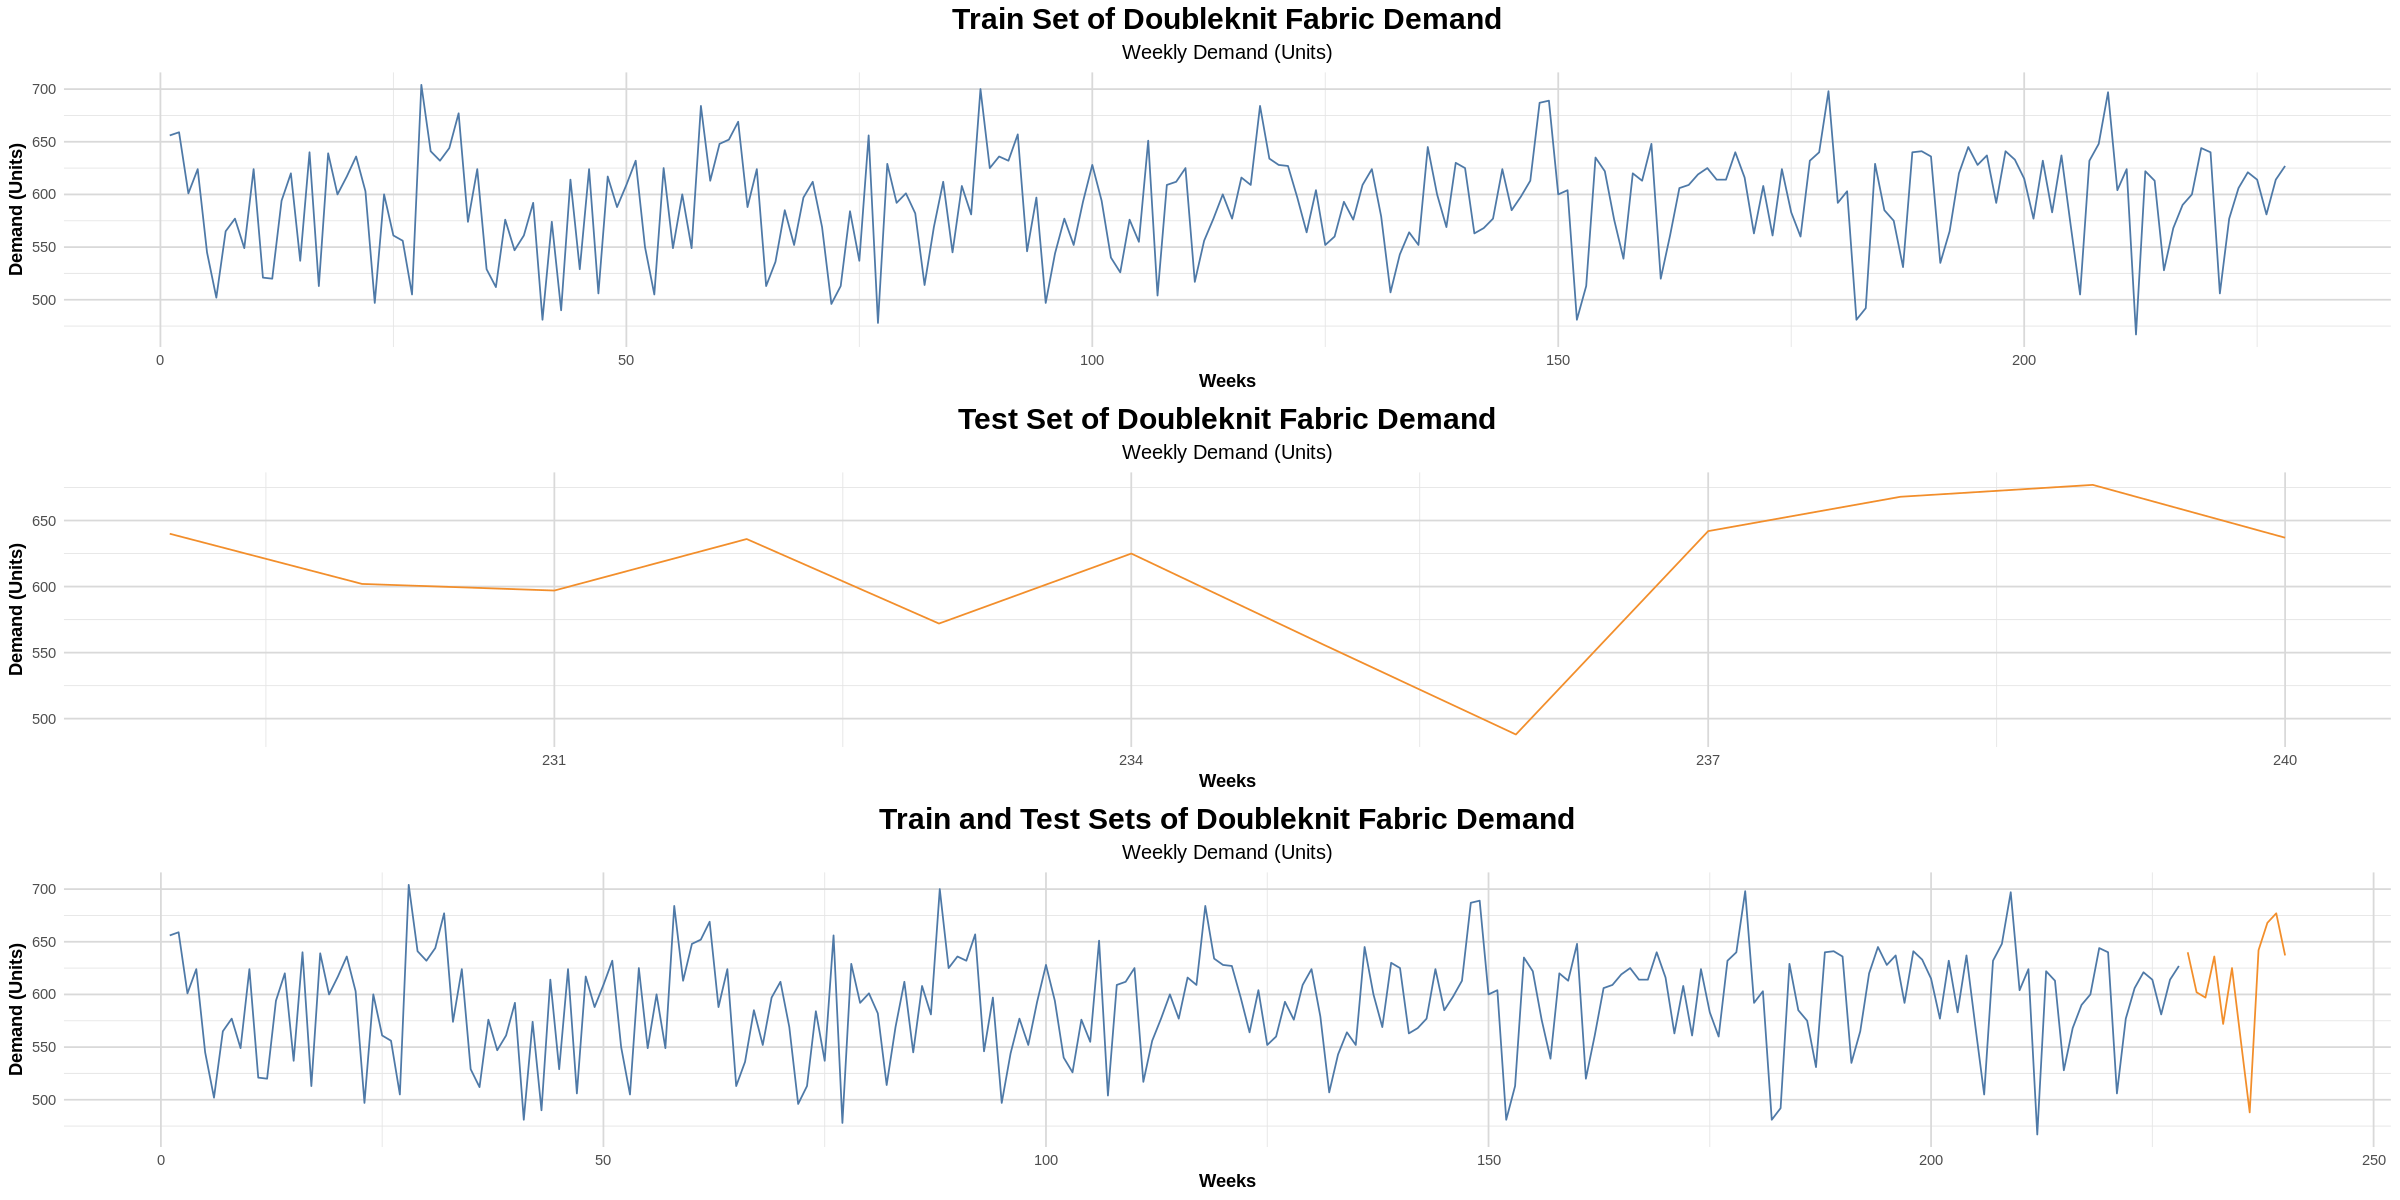

In [10]:
# devide into train and test sets
train_size <- round(0.95 * nrow(fabric_ts_df))
train <- fabric_ts_df$x[1:train_size]
test <- fabric_ts_df$x[(train_size + 1):nrow(fabric_ts_df)]
train_df <- fabric_ts_df[1:train_size, ]
test_df <- fabric_ts_df[(train_size + 1):nrow(fabric_ts_df), ]
# plotting the train and test sets

p2 <- ggplot(train_df, aes(x = week, y = x)) +
  geom_line(color = "#4E79A7") +
  labs(
    title = "Train Set of Doubleknit Fabric Demand",
    subtitle = "Weekly Demand (Units)",
    x = "Weeks",
    y = "Demand (Units)"
  ) +
  theme_tsa()
p3 <- ggplot(test_df, aes(x = week, y = x)) +
  geom_line(color = "#F28E2B") +
  labs(
    title = "Test Set of Doubleknit Fabric Demand",
    subtitle = "Weekly Demand (Units)",
    x = "Weeks",
    y = "Demand (Units)"
  ) +
  theme_tsa()
p4 <- ggplot() +
  geom_line(data = train_df, aes(x = week, y = x), color = "#4E79A7") +
  geom_line(data = test_df, aes(x = week, y = x), color = "#F28E2B") +
  labs(
    title = "Train and Test Sets of Doubleknit Fabric Demand",
    subtitle = "Weekly Demand (Units)",
    x = "Weeks",
    y = "Demand (Units)"
  ) +
  theme_tsa()
grid.arrange(p2, p3, p4, ncol = 1)

### ***Stationarity Test***

In [11]:
adf_test <- adf.test(train)
kpss_test <- kpss.test(train)

cat("Augmented Dickey-Fuller Test:\n")
if (adf_test$p.value < 0.05) {
  cat("The time series is stationary (p-value:", adf_test$p.value,")\n")
} else {
  cat("The time series is non-stationary (p-value:", adf_test$p.value,")\n")
}

cat("\nKPSS Test:\n")
if (kpss_test$p.value < 0.05) {
  cat("The time series is non-stationary (p-value:", kpss_test$p.value,")\n")
} else {
  cat("The time series is stationary (p-value:", kpss_test$p.value,")\n")
}

Warning message in adf.test(train):
“p-value smaller than printed p-value”
Warning message in kpss.test(train):
“p-value greater than printed p-value”


Augmented Dickey-Fuller Test:
The time series is stationary (p-value: 0.01 )

KPSS Test:
The time series is stationary (p-value: 0.1 )


Series is stationary no need for differencing

### ***Transformation***

Confidence interval for lambda: [ 1.171717 , 3.757576 ]


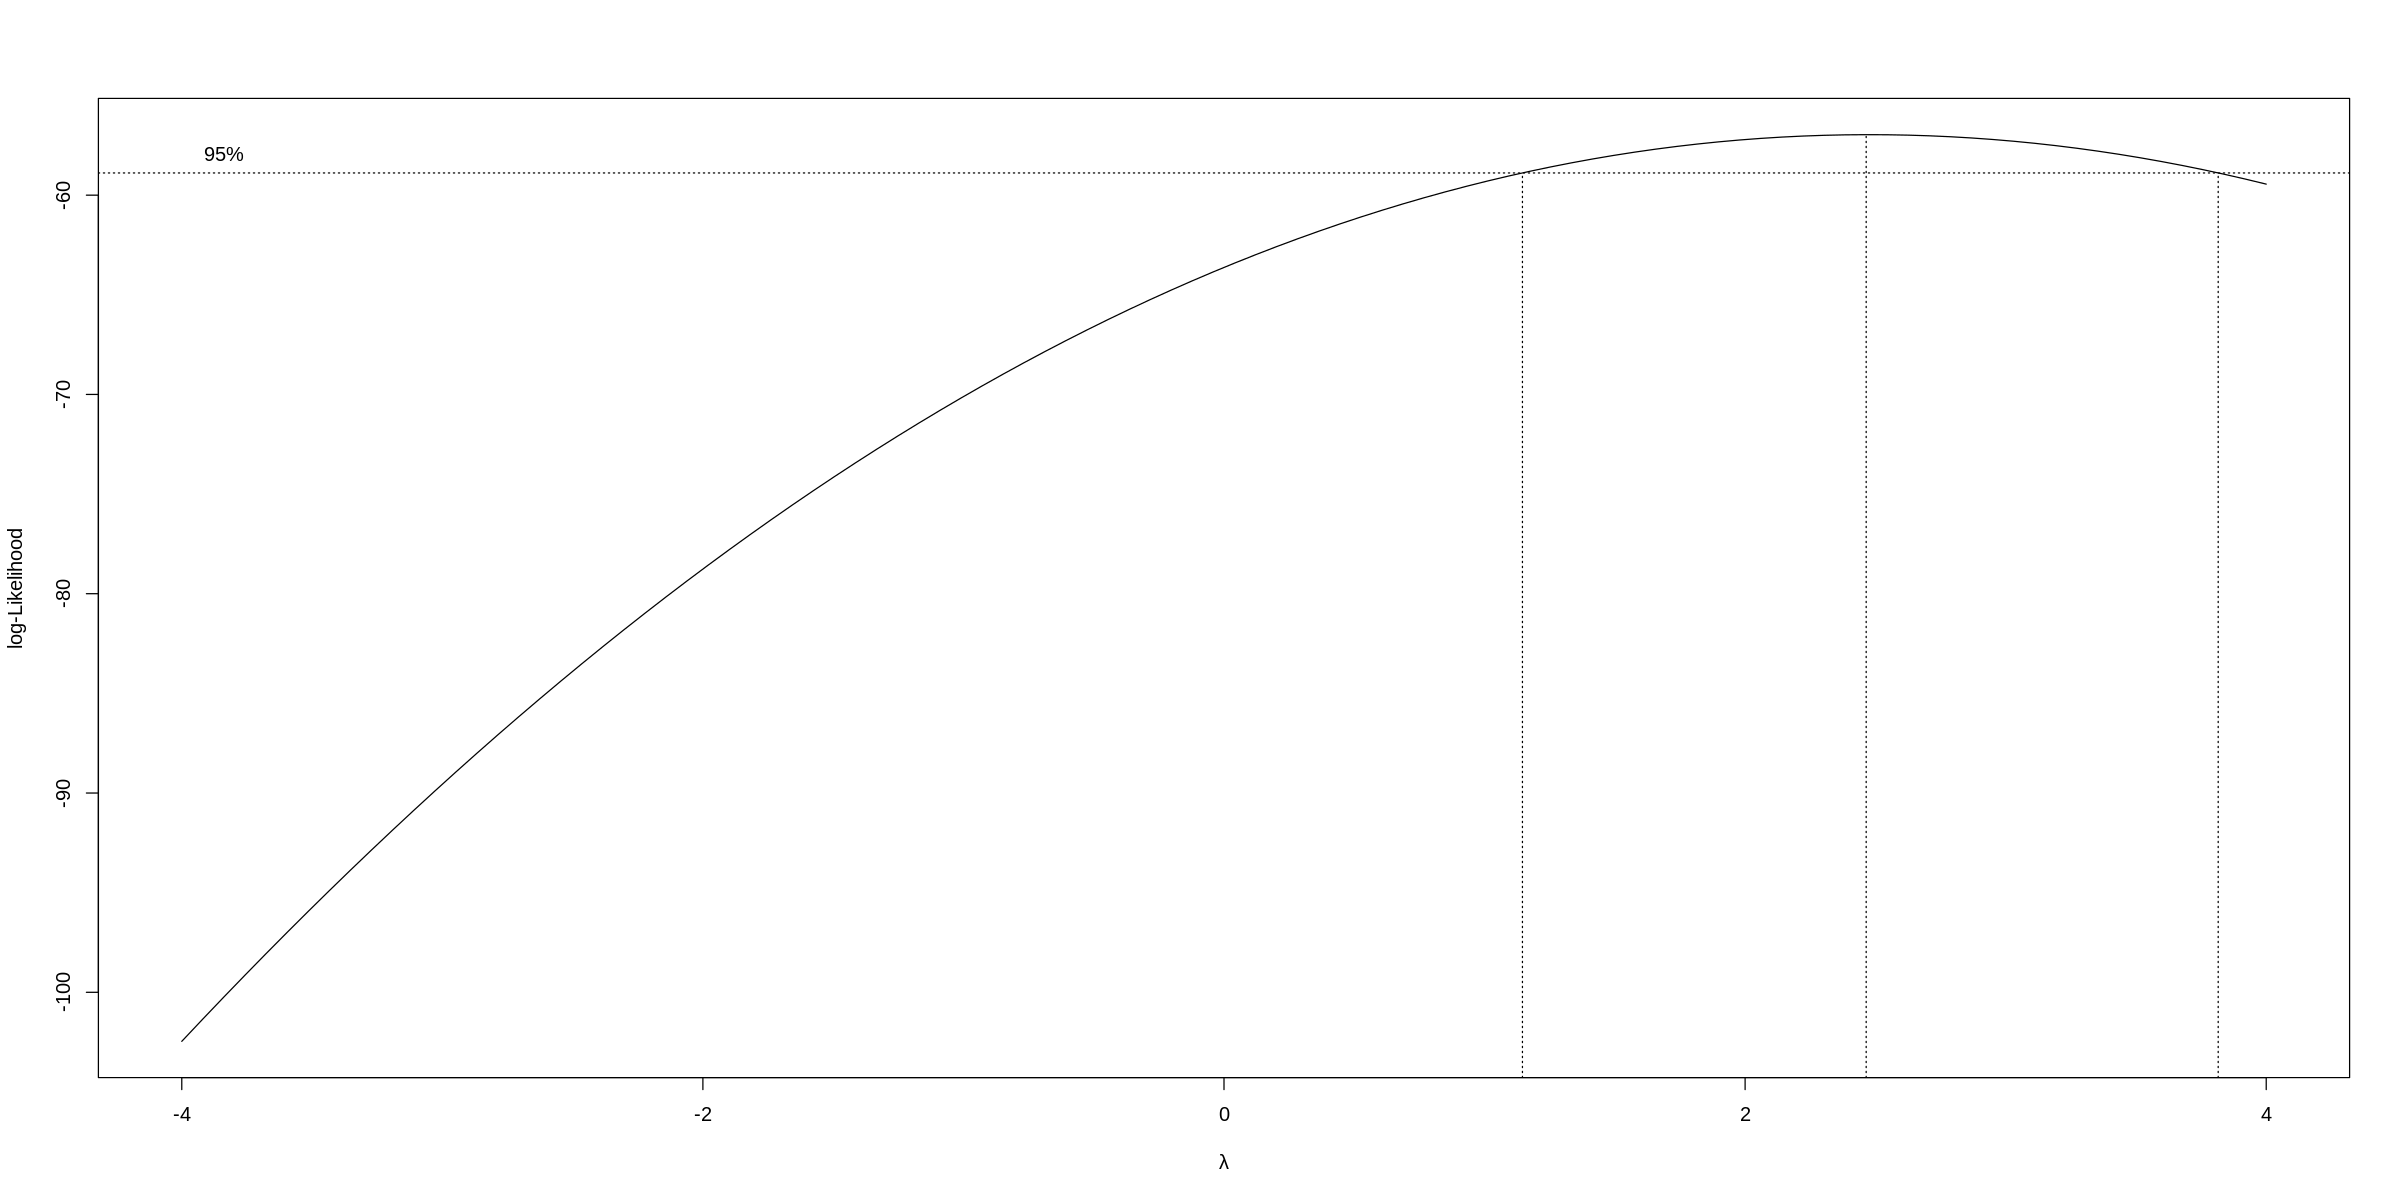

In [12]:
model <- lm(x ~ as.numeric(week), data = data)
par(bg = "white")
boxcox_result <- boxcox(model, lambda = seq(-4, 4, by = 0.1))

lambda_interval <- boxcox_result$x[boxcox_result$y > max(boxcox_result$y)
                                   - qchisq(0.95, df = 1) / 2]

cat("Confidence interval for lambda: [", min(lambda_interval), ",",
    max(lambda_interval), "]\n")

The previous plot suggests that optimal value for $ \lambda $ is in the interval $ [1.17, 3.75] $

We can take $ \lambda = 2 $ and apply a quadratic transformation.

In [13]:
# apply the transformation lambda = 2

lambda <- 2
train_transformed <- BoxCox(train, lambda)

train_transformed_df <- data.frame(
  week = seq(1, length(train_transformed)),
  x = train_transformed
)

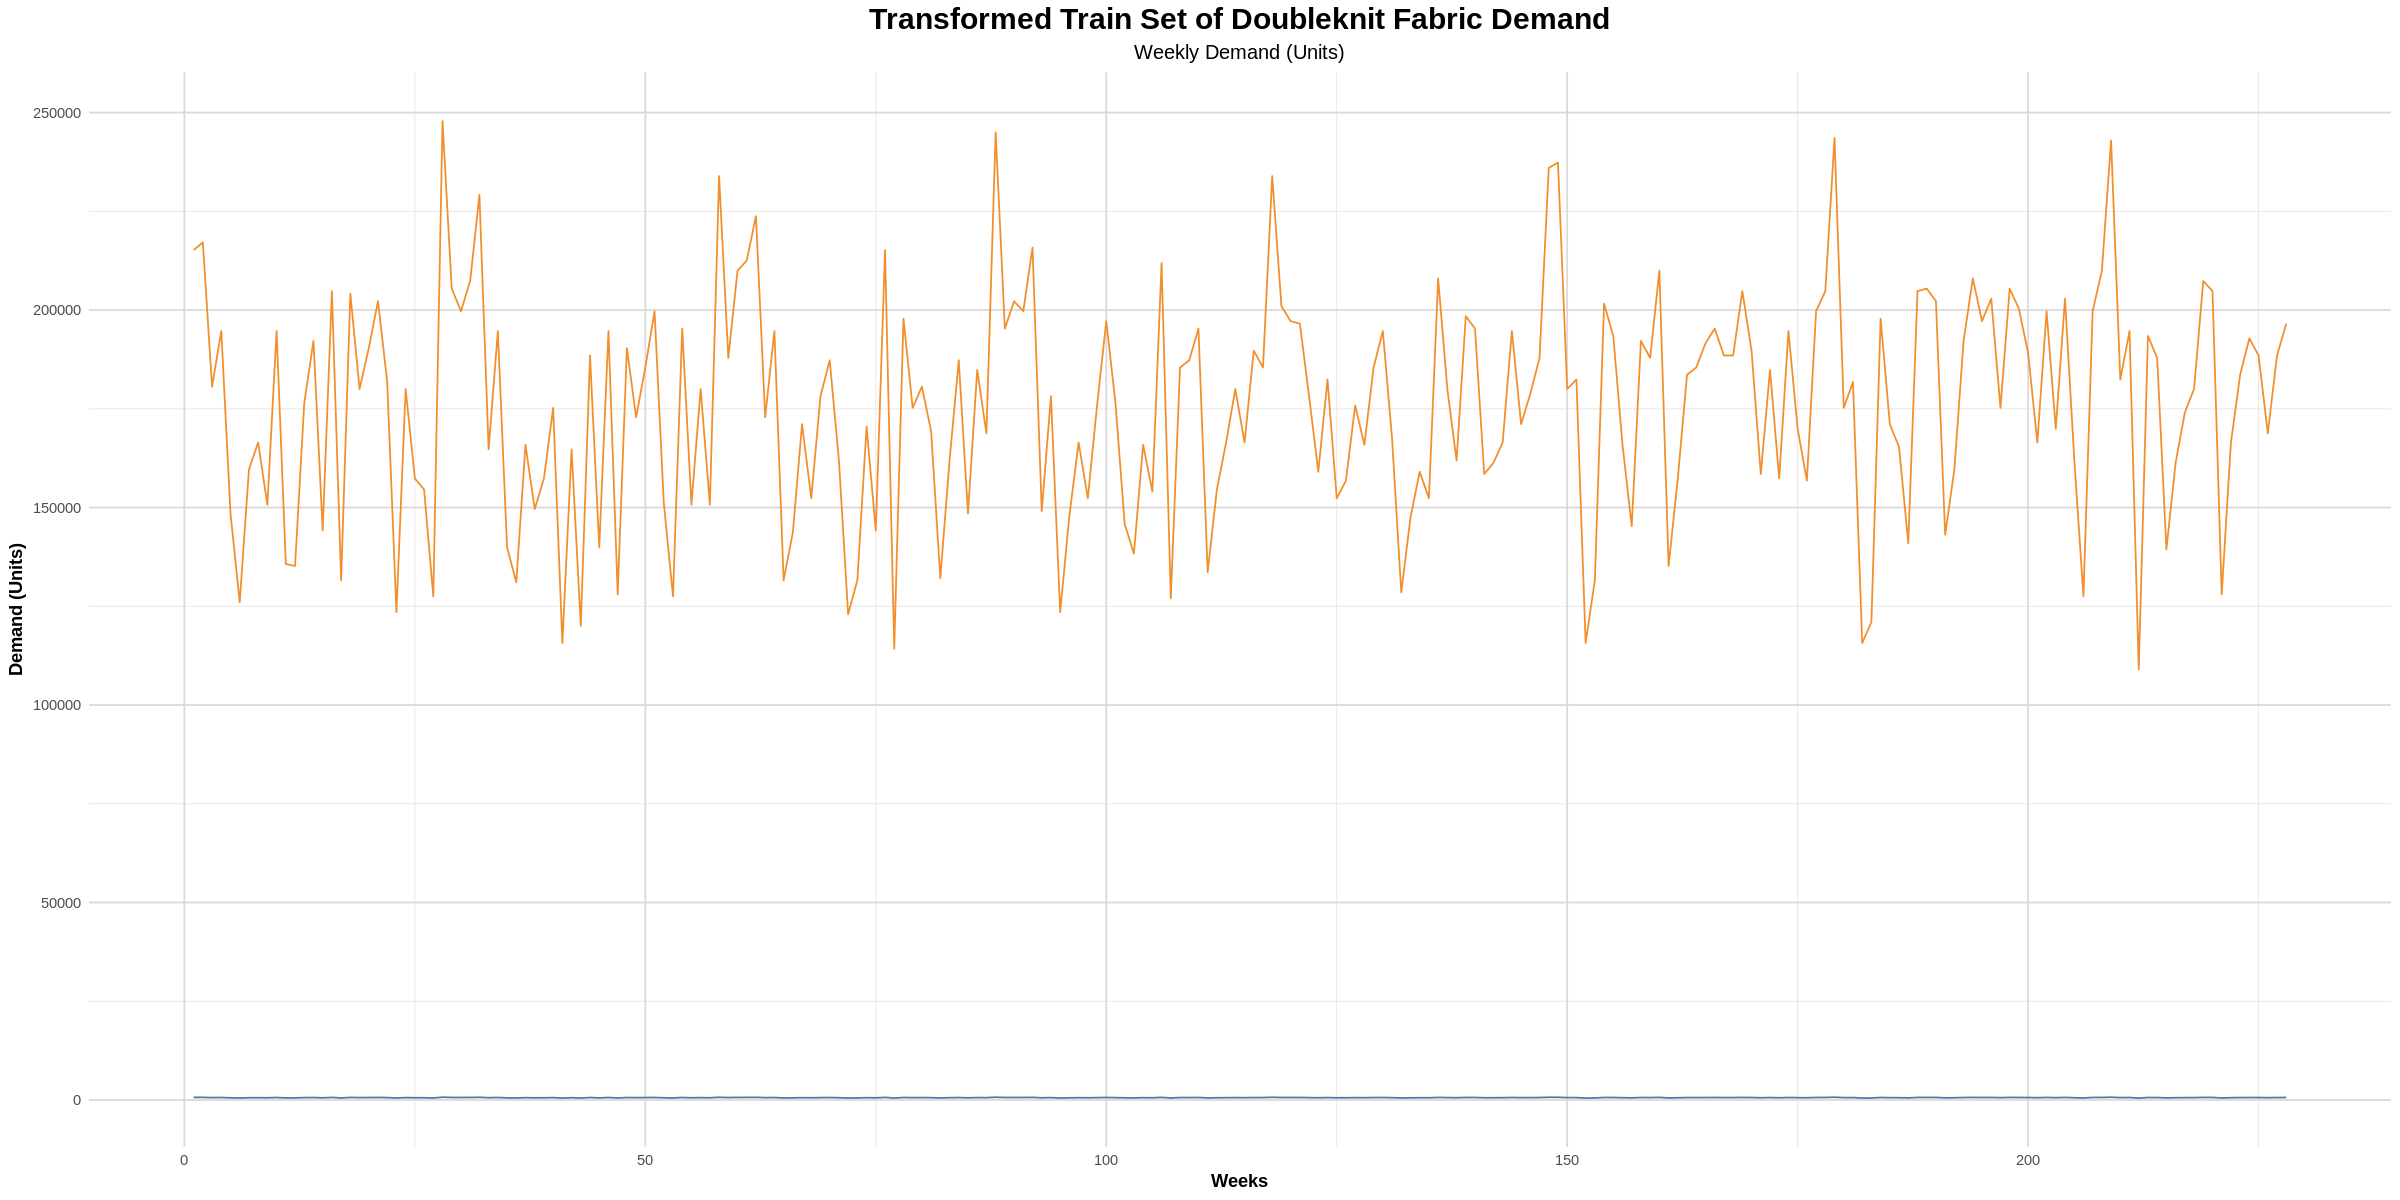

In [14]:
# plot the transformed train compared to the original train

p5 <- ggplot() +
  geom_line(data = train_df, aes(x = week, y = x), color = "#4E79A7") +
  geom_line(data = train_transformed_df, aes(x = week, y = x), color = "#F28E2B") +
  labs(
    title = "Transformed Train Set of Doubleknit Fabric Demand",
    subtitle = "Weekly Demand (Units)",
    x = "Weeks",
    y = "Demand (Units)"
  ) +
  theme_tsa()
print(p5)

### ***ACF & PACF Analysis***

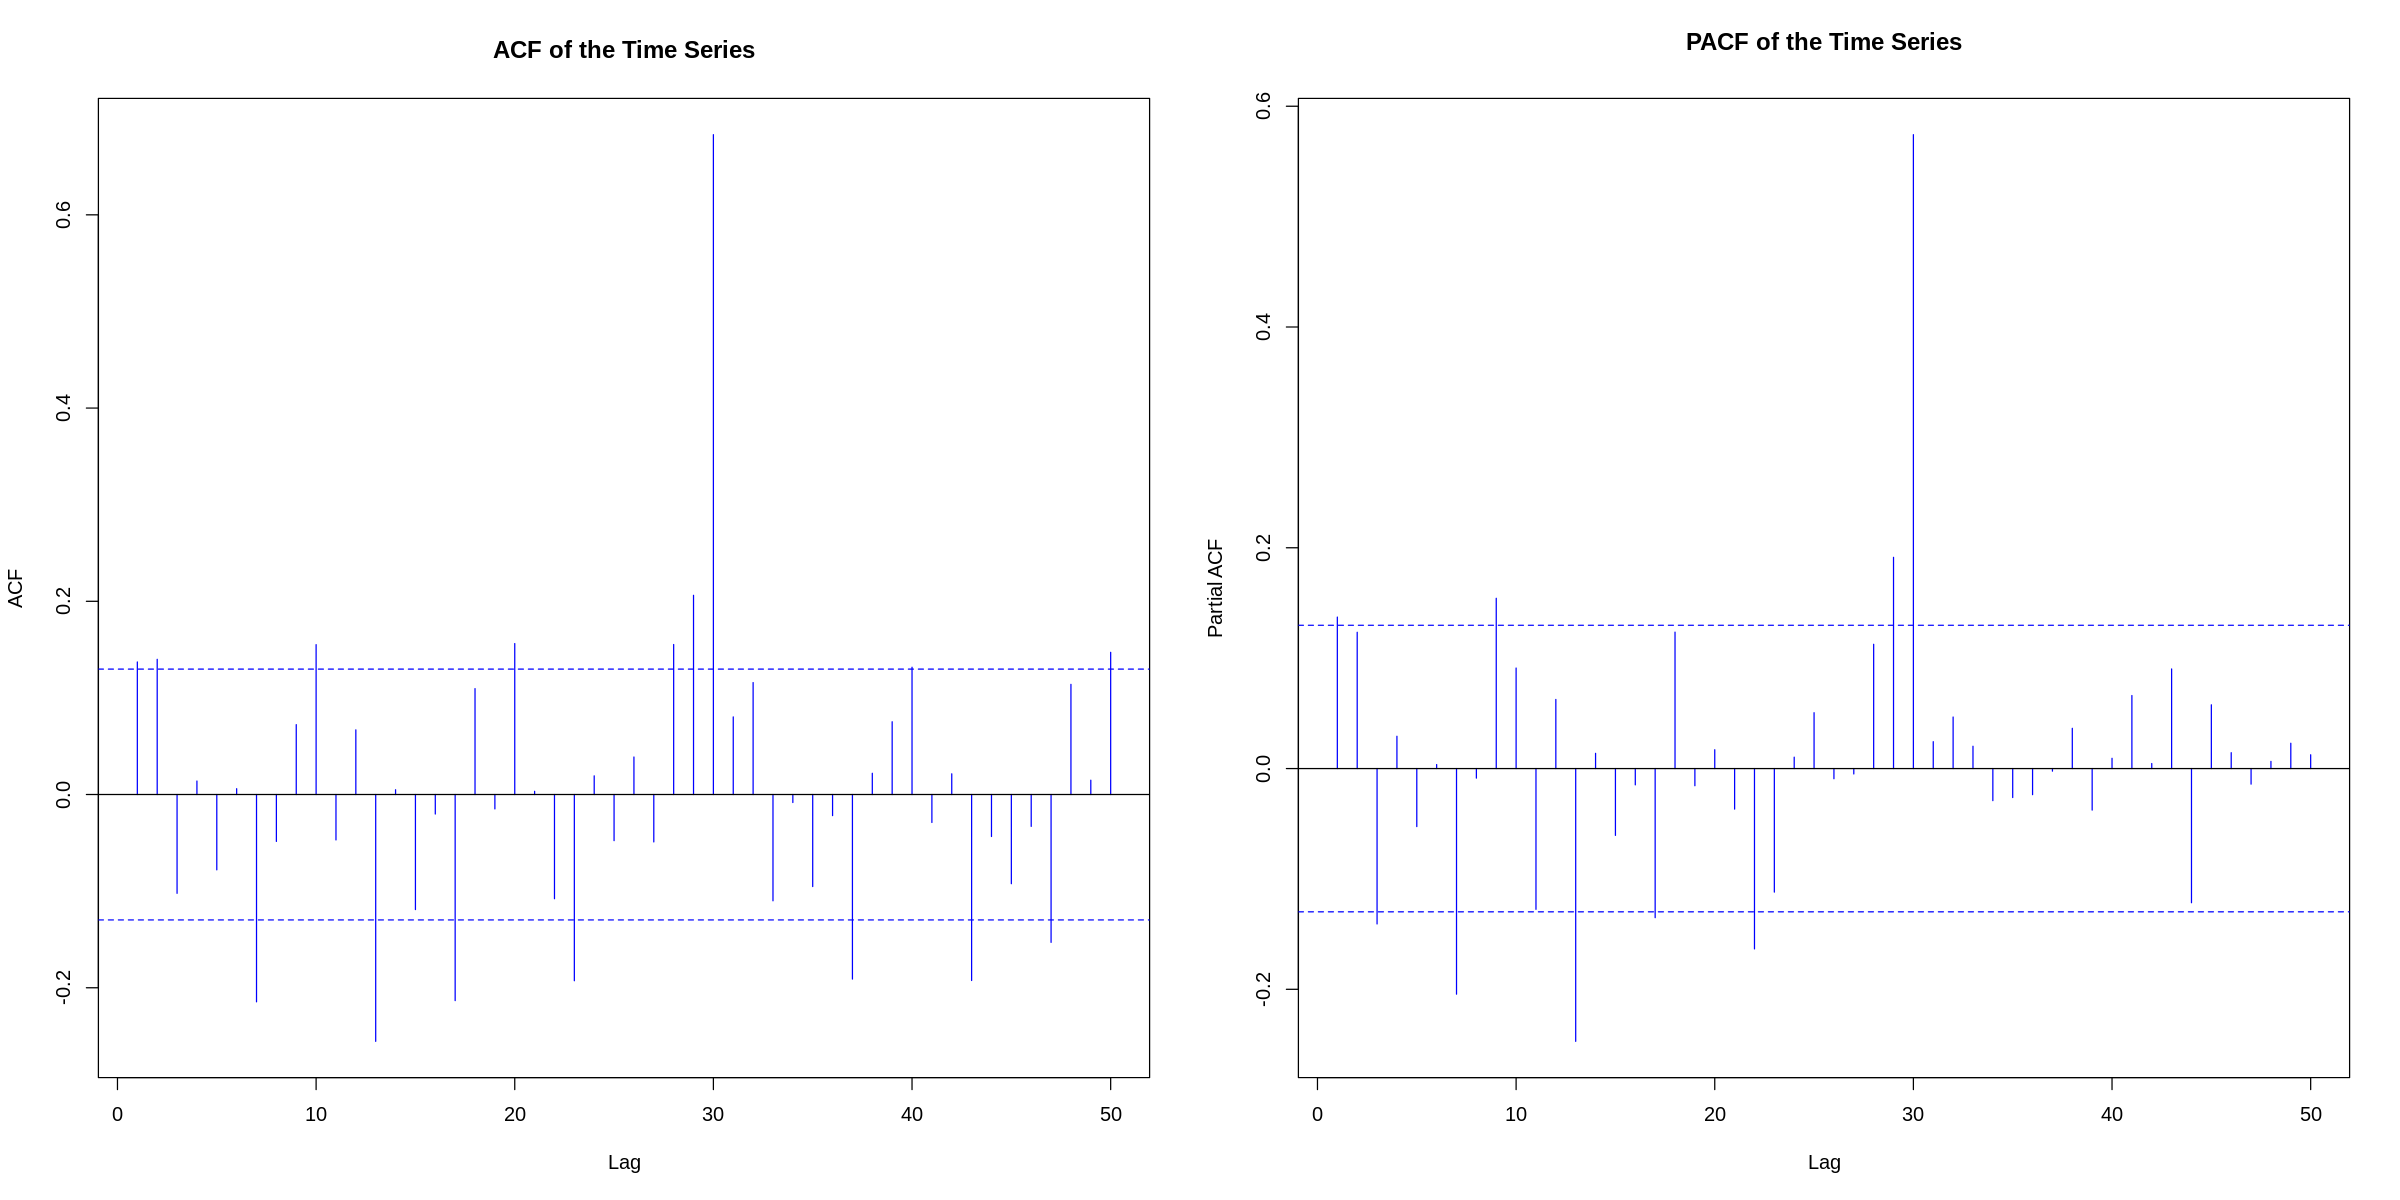

In [15]:
# plot ACF & PACF and examine them

par(mfrow = c(1, 2),bg = "white")
acf(train_transformed, main = "ACF of the Time Series", lag.max = 50, col = "blue")
pacf(train_transformed, main = "PACF of the Time Series", lag.max = 50, col = "blue")


Upon analyzing the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** graphs, we observe **significant spikes** in the **advanced lags**. This suggests the presence of **higher-order** autoregressive (**AR**) and moving average (**MA**) components in the time series.  

To account for this, we will **expand our search grid** for model selection, setting the range of parameters **(p, q) = (10, 10)**. This broader search space will help us identify the most **optimal ARMA configuration** for improved forecasting accuracy.


## **Phase II: Estimating and Testing**

Since the ACF and PACF plots show a significant number of lags and the order of differencing is 0, we can use an ARMA model we will an fit ARMA model, testing the hypothesis we discussed in the end of the previous section.

### ***Model Identification Using `armasubsets()`***



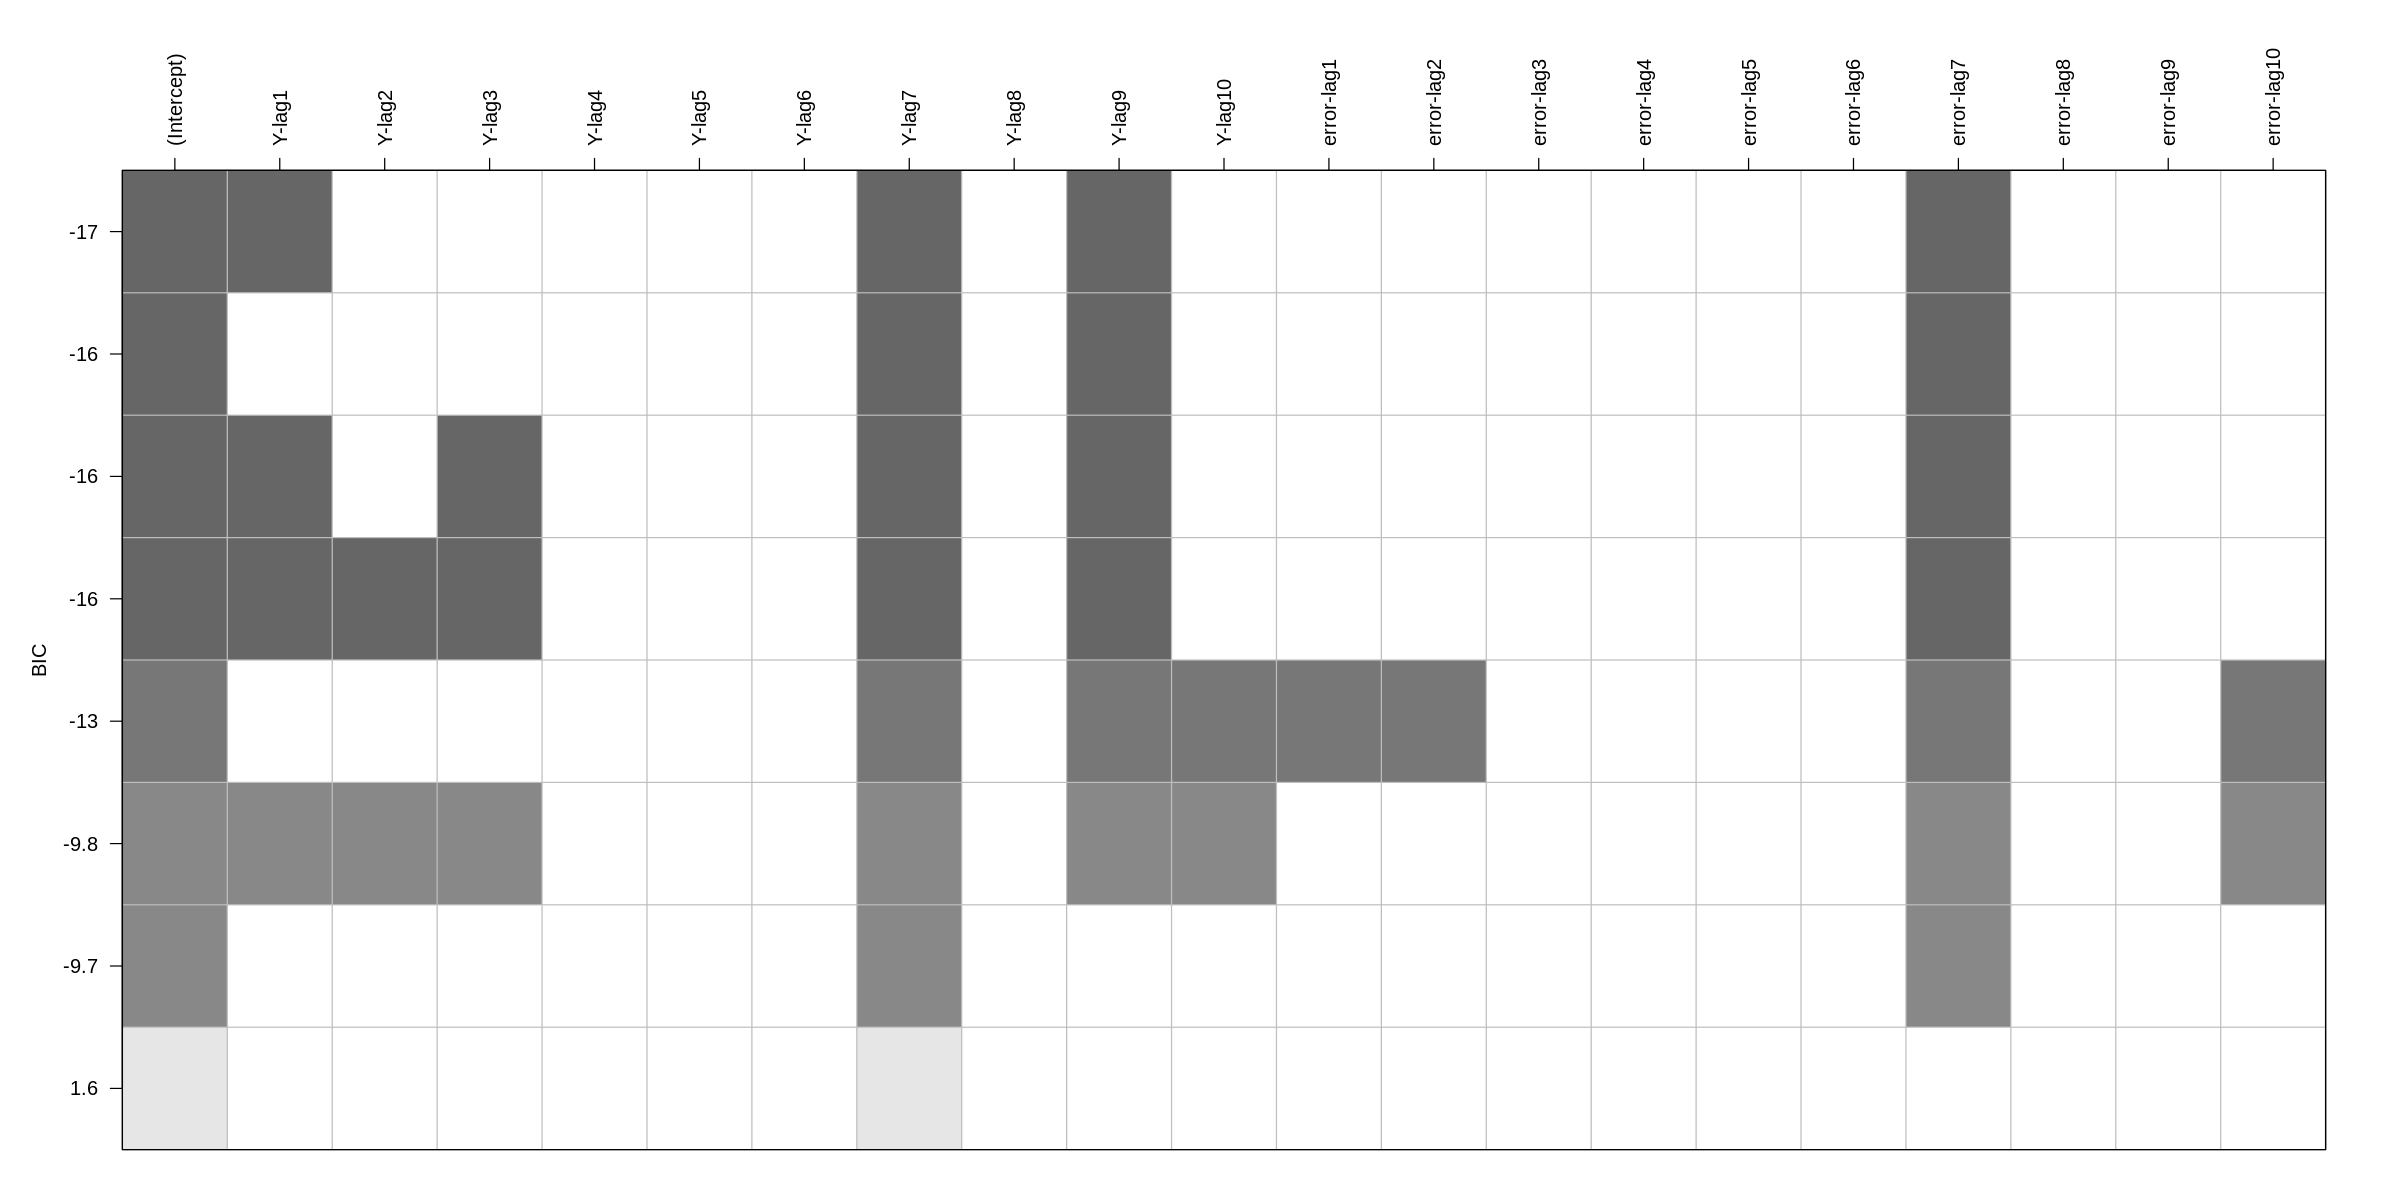

In [16]:
# selecting the best ARMA using armasubsets()

arma_subsets <- armasubsets(train_transformed, 10, 10)
par(bg = "white")
plot(arma_subsets)

From the plot, we can see that the best model found by `armasubsets()` is **ARMA(9,7)**

### ***Model Identification Using grid search***

In [17]:
# select the best ARMA model based on BIC using grid search
# and display the best model order and BIC value

best_bic <- Inf
best_order <- c(0, 0)
best_model <- NULL

for (p in 0:10) {
  for (q in 0:10) {
    model <- tryCatch(
      Arima(train_transformed, order = c(p, 0, q)),
      error = function(e) NULL
    )
    if (!is.null(model)) {
      bic <- BIC(model)
      if (bic < best_bic) {
        best_bic <- bic
        best_order <- c(p, q)
        best_model <- model
      }
    }
  }
}

cat("Best ARMA model order (p, q):", best_order, "\n")
cat("BIC of the best ARMA model:", best_bic, "\n")

Best ARMA model order (p, q): 2 1 
BIC of the best ARMA model: 5327.85 


In [18]:
# using grid search to find the best ARMA again using AIC

best_aic <- Inf
best_order_aic <- c(0, 0)
best_model_aic <- NULL

for (p in 0:10) {
  for (q in 0:10) {
    model <- tryCatch(
      Arima(train_transformed, order = c(p, 0, q)),
      error = function(e) NULL
    )

    if (!is.null(model)) {
      aic <- AIC(model)  # Use AIC instead of AICc
      if (aic < best_aic) {
        best_aic <- aic
        best_order_aic <- c(p, q)
        best_model_aic <- model
      }
    }
  }
}

cat("Best ARMA model order (p, q) using AIC:", best_order_aic, "\n")
cat("AIC of the best ARMA model:", best_aic, "\n")

Best ARMA model order (p, q) using AIC: 8 6 
AIC of the best ARMA model: 5279.694 


#### **Analysis of ARMA Model Selection Using AIC and BIC**

---



When selecting the best ARMA(\(p, q\)) model, we use two main criteria: **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)**. These criteria help balance model fit and complexity.

An **ARMA(\(p, q\))** model is defined as:

$$
Y_t = c + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$$


1. **Best Model by AIC: ARMA(8,6)**

   $$
   Y_t = c + \sum_{i=1}^{8} \phi_i Y_{t-i} + \sum_{j=1}^{6} \theta_j \varepsilon_{t-j} + \varepsilon_t
   $$

   - This model minimizes AIC = **5279.694**, meaning it has a good balance between fit and complexity.

2. **Best Model by BIC: ARMA(2,1)**

   $$
   Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \theta_1 \varepsilon_{t-1} + \varepsilon_t
   $$

   - This model minimizes BIC = **5327.85**, meaning it favors simplicity while maintaining a reasonable fit.

3. **Model Suggested by `armasubsets()`: ARMA(9,7)**

   $$
   Y_t = c + \sum_{i=1}^{9} \phi_i Y_{t-i} + \sum_{j=1}^{7} \theta_j \varepsilon_{t-j} + \varepsilon_t
   $$

   - This is the model identified by `armasubsets()`, which may have the best empirical fit but is likely penalized by BIC due to complexity.

---

BIC is designed with **parsimony** in mind, meaning it prefers simpler models unless additional complexity provides significant improvements in fit. This is because BIC includes a stronger penalty for model complexity compared to AIC.

Since BIC scales the penalty by \( \ln n \), it penalizes additional parameters more strongly, particularly for large datasets. This is why BIC selects **ARMA(2,1)**, which has fewer parameters than **ARMA(8,6)** or **ARMA(9,7)**.

---

- **AIC prefers ARMA(8,6)** because it provides the best trade-off between likelihood and complexity.
- **BIC prefers ARMA(2,1)** because it aggressively penalizes extra parameters, favoring a more parsimonious model.
- **`armasubsets()` suggests ARMA(9,7)** based purely on in-sample fit, but BIC discourages such a complex model.


### ***Parameter Estimation***

In [19]:
# Estimate the parameters of the three identified ARMA models using MLE

# Model 1: ARMA(2,1) - Best model by BIC
model_bic <- Arima(train_transformed, order = c(2, 0, 1))
summary(model_bic)

# Model 2: ARMA(8,6) - Best model by AIC
model_aic <- Arima(train_transformed, order = c(8, 0, 6))
summary(model_aic)

# Model 3: ARMA(9,7) - Model suggested by armasubsets()
model_armasub <- Arima(train_transformed, order = c(9, 0, 7))
summary(model_armasub)

# Create a comparison table of key statistics
model_comparison <- data.frame(
    Model = c("ARMA(2,1)", "ARMA(8,6)", "ARMA(9,7)"),
    AIC = c(AIC(model_bic), AIC(model_aic), AIC(model_armasub)),
    BIC = c(BIC(model_bic), BIC(model_aic), BIC(model_armasub)),
    Log_Likelihood = c(model_bic$loglik, model_aic$loglik, model_armasub$loglik)
)

kable(model_comparison, caption = "Comparison of ARMA Models", digits = 2)

Series: train_transformed 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ma1        mean
      -0.7560  0.2401  0.9711  175678.765
s.e.   0.0657  0.0653  0.0157    2320.631

sigma^2 = 741137614:  log likelihood = -2650.35
AIC=5310.7   AICc=5310.97   BIC=5327.85

Training set error measures:
                    ME     RMSE      MAE       MPE    MAPE      MASE
Training set -74.90003 26983.98 21709.61 -2.642223 13.2349 0.7338499
                     ACF1
Training set -0.006363127

Series: train_transformed 
ARIMA(8,0,6) with non-zero mean 

Coefficients:
          ar1      ar2      ar3      ar4      ar5     ar6      ar7      ar8
      -0.5256  -0.5189  -0.4232  -0.1255  -0.1689  0.4628  -0.3174  -0.2630
s.e.   0.2238   0.2318   0.2855   0.2591   0.1842  0.1352   0.1005   0.0684
         ma1     ma2     ma3     ma4     ma5      ma6        mean
      0.7332  0.9043  0.6868  0.3682  0.1951  -0.5555  175580.252
s.e.  0.2291  0.2935  0.3788  0.3766  0.2996   0.2188    1805.881

sigma^2 = 588826944:  log likelihood = -2623.85
AIC=5279.69   AICc=5282.27   BIC=5334.56

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set -38.4516 23453.96 18748.69 -2.052091 11.38155 0.6337619
                     ACF1
Training set -0.009333334

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


Series: train_transformed 
ARIMA(9,0,7) with non-zero mean 

Coefficients:
         ar1      ar2     ar3     ar4      ar5     ar6      ar7     ar8     ar9
      0.4586  -0.0059  0.0836  0.2841  -0.0502  0.6260  -0.7746  0.0507  0.2603
s.e.  0.0994   0.0657  0.0408  0.0396   0.0720  0.0547   0.1222  0.0788  0.0653
          ma1     ma2      ma3      ma4      ma5      ma6     ma7        mean
      -0.2494  0.1884  -0.2042  -0.2930  -0.1623  -0.7452  0.5551  175611.283
s.e.   0.0970     NaN      NaN   0.0093   0.0796   0.0802  0.1366    2015.307

sigma^2 = 592120193:  log likelihood = -2623.69
AIC=5283.39   AICc=5286.66   BIC=5345.12

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE     MASE
Training set 33.28565 23408.78 18705.36 -2.006201 11.35051 0.632297
                     ACF1
Training set -0.009283089



Table: Comparison of ARMA Models

|Model     |     AIC|     BIC| Log_Likelihood|
|:---------|-------:|-------:|--------------:|
|ARMA(2,1) | 5310.70| 5327.85|       -2650.35|
|ARMA(8,6) | 5279.69| 5334.56|       -2623.85|
|ARMA(9,7) | 5283.39| 5345.12|       -2623.69|

**Here is a summary of tue results**

## Model Equations

Below are the mathematical representations of the three ARIMA models fitted to the transformed doubleknit fabric demand data.

### 1. ARIMA(2,0,1) with non-zero mean

#### General Form
$$X_t = \mu + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \theta_1 \varepsilon_{t-1} + \varepsilon_t$$

#### Model with Coefficient Values
$$X_t = 175678.765 - 0.7560 X_{t-1} + 0.2401 X_{t-2} + 0.9711 \varepsilon_{t-1} + \varepsilon_t$$

Where $\varepsilon_t \sim N(0, 741137614)$

### 2. ARIMA(8,0,6) with non-zero mean

#### General Form
$$X_t = \mu + \sum_{i=1}^{8} \phi_i X_{t-i} + \sum_{j=1}^{6} \theta_j \varepsilon_{t-j} + \varepsilon_t$$

#### Model with Coefficient Values
$$\begin{align}
X_t = 175580.252 &- 0.5256 X_{t-1} - 0.5189 X_{t-2} - 0.4232 X_{t-3} - 0.1255 X_{t-4} \\
&- 0.1689 X_{t-5} + 0.4628 X_{t-6} - 0.3174 X_{t-7} - 0.2630 X_{t-8} \\
&+ 0.7332 \varepsilon_{t-1} + 0.9043 \varepsilon_{t-2} + 0.6868 \varepsilon_{t-3} \\
&+ 0.3682 \varepsilon_{t-4} + 0.1951 \varepsilon_{t-5} - 0.5555 \varepsilon_{t-6} + \varepsilon_t
\end{align}$$

Where $\varepsilon_t \sim N(0, 588826944)$

### 3. ARIMA(9,0,7) with non-zero mean

#### General Form
$$X_t = \mu + \sum_{i=1}^{9} \phi_i X_{t-i} + \sum_{j=1}^{7} \theta_j \varepsilon_{t-j} + \varepsilon_t$$

#### Model with Coefficient Values
$$\begin{align}
X_t = 175611.283 &+ 0.4586 X_{t-1} - 0.0059 X_{t-2} + 0.0836 X_{t-3} + 0.2841 X_{t-4} \\
&- 0.0502 X_{t-5} + 0.6260 X_{t-6} - 0.7746 X_{t-7} + 0.0507 X_{t-8} + 0.2603 X_{t-9} \\
&- 0.2494 \varepsilon_{t-1} + 0.1884 \varepsilon_{t-2} - 0.2042 \varepsilon_{t-3} - 0.2930 \varepsilon_{t-4} \\
&- 0.1623 \varepsilon_{t-5} - 0.7452 \varepsilon_{t-6} + 0.5551 \varepsilon_{t-7} + \varepsilon_t
\end{align}$$

Where $\varepsilon_t \sim N(0, 592120193)$


### ***Models Diagnosis***



==== DIAGNOSTICS FOR ARMA(2,1) - BIC choice ====

Ljung-Box test (lag=20):
  Q = 40.6587 , p-value = 0.0041 
   Reject H0: Residuals have autocorrelation 

Shapiro-Wilk normality test:
  W = 0.9897 , p-value = 0.1058 
   Fail to reject H0: Residuals are normal 

ARCH test (lag=12):
  Chi-square = 14.555 , p-value = 0.2667 
   Fail to reject H0: No ARCH effects 

Runs test:
  Z = 0 , p-value = 1 
   Fail to reject H0: Residuals are random 



==== DIAGNOSTICS FOR ARMA(8,6) - AIC choice ====

Ljung-Box test (lag=20):
  Q = 22.557 , p-value = 0.3111 
   Fail to reject H0: Residuals are white noise 

Shapiro-Wilk normality test:
  W = 0.9924 , p-value = 0.2861 
   Fail to reject H0: Residuals are normal 

ARCH test (lag=12):
  Chi-square = 17.7584 , p-value = 0.1232 
   Fail to reject H0: No ARCH effects 

Runs test:
  Z = 1.9912 , p-value = 0.0465 
   Reject H0: Residuals are not random 



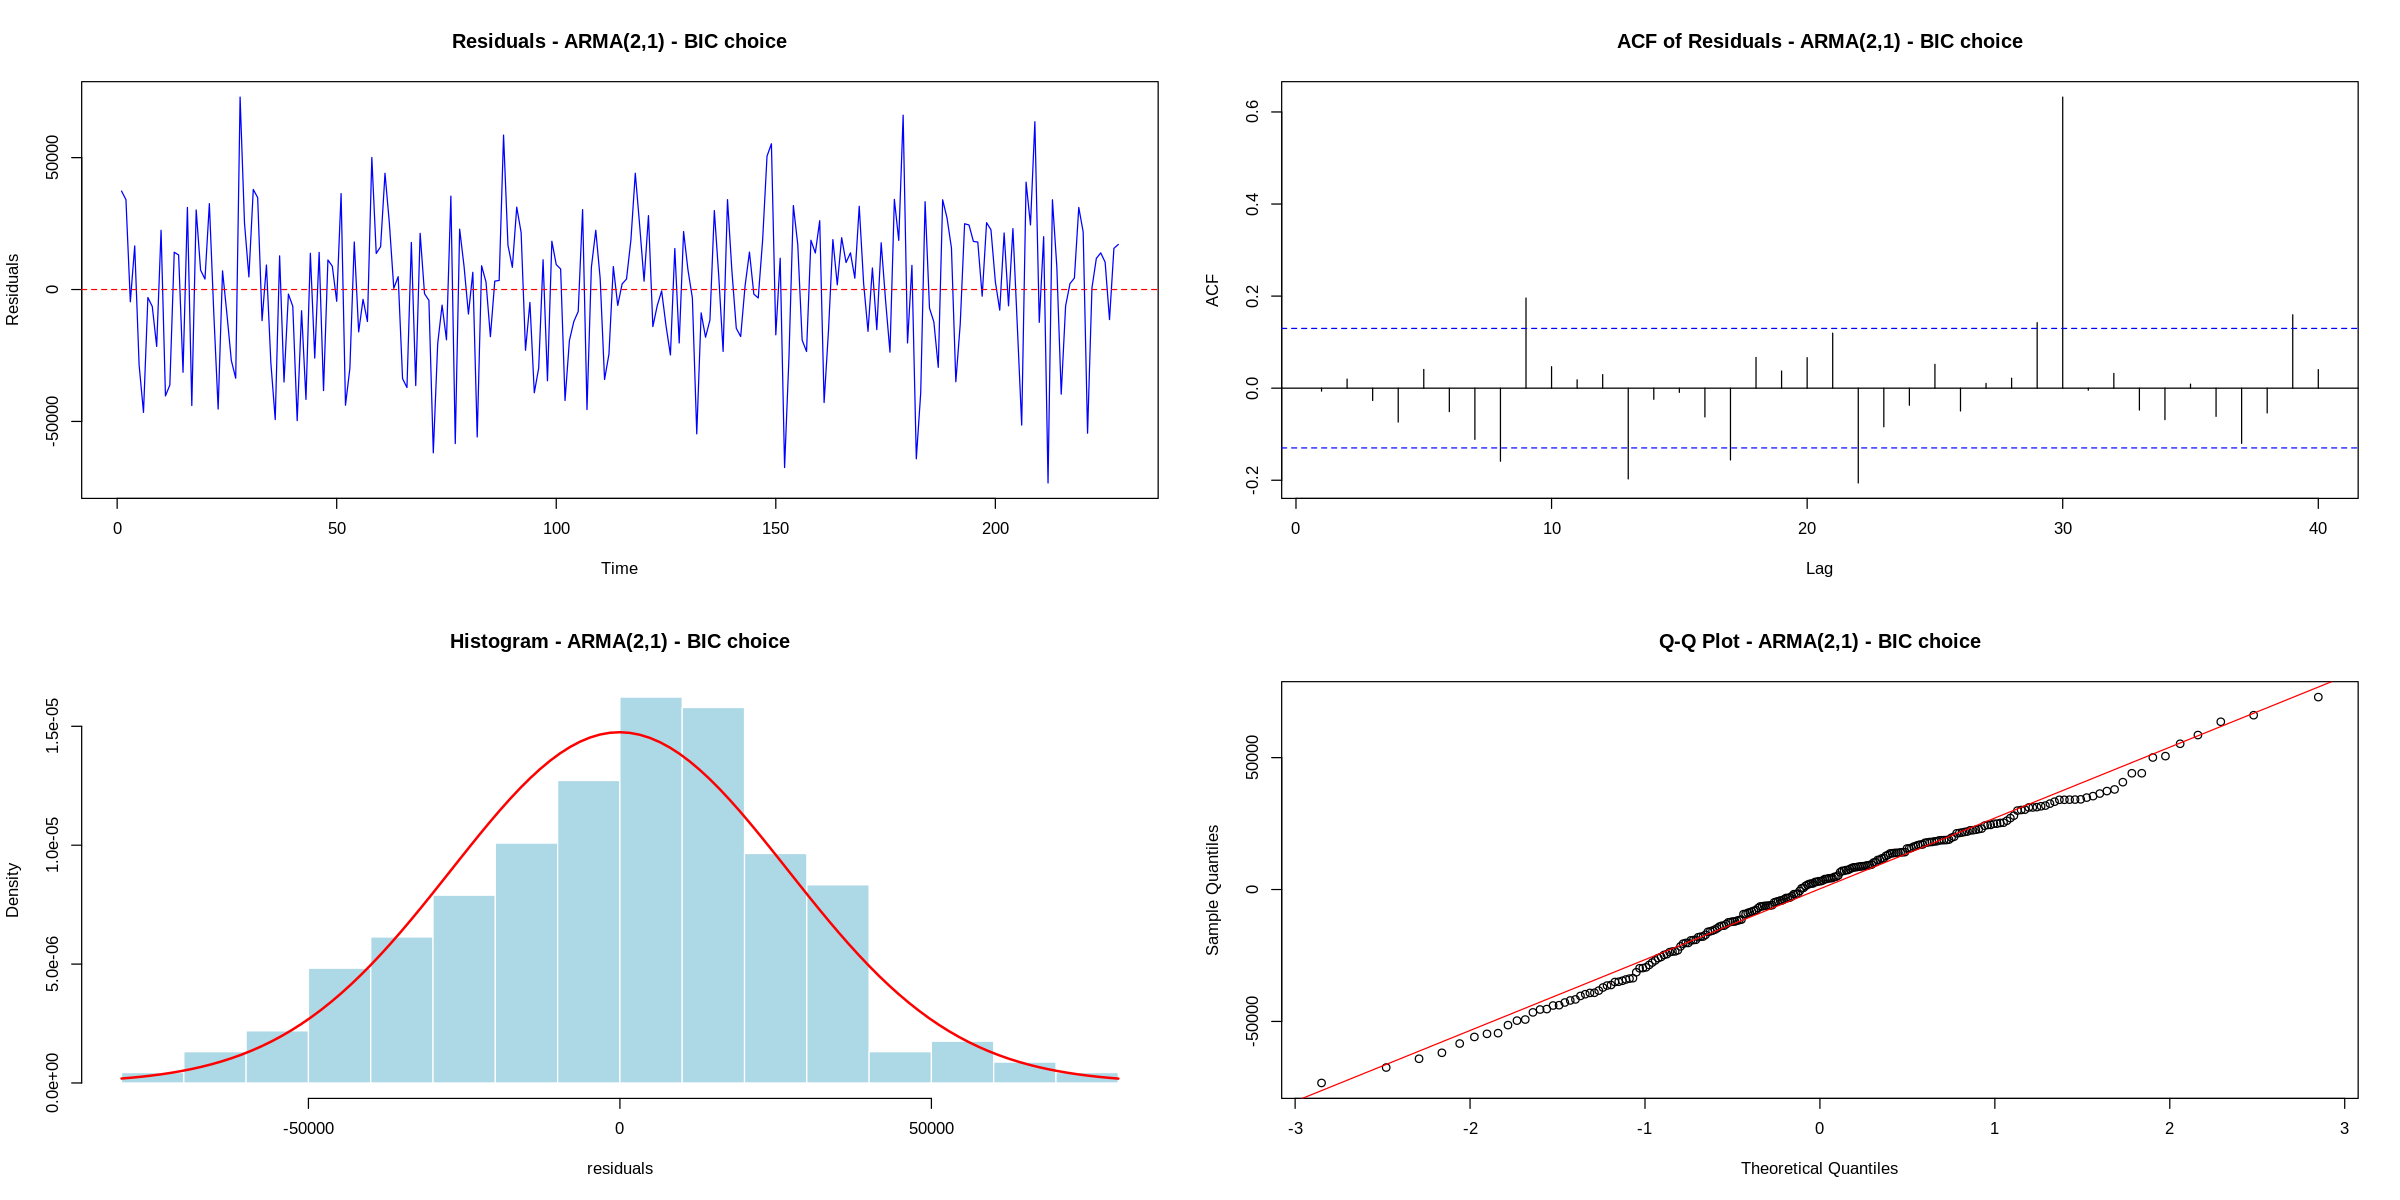



==== DIAGNOSTICS FOR ARMA(9,7) - ARMA subsets choice ====

Ljung-Box test (lag=20):
  Q = 23.2103 , p-value = 0.2786 
   Fail to reject H0: Residuals are white noise 

Shapiro-Wilk normality test:
  W = 0.9923 , p-value = 0.2748 
   Fail to reject H0: Residuals are normal 

ARCH test (lag=12):
  Chi-square = 17.72 , p-value = 0.1245 
   Fail to reject H0: No ARCH effects 

Runs test:
  Z = 1.9912 , p-value = 0.0465 
   Reject H0: Residuals are not random 



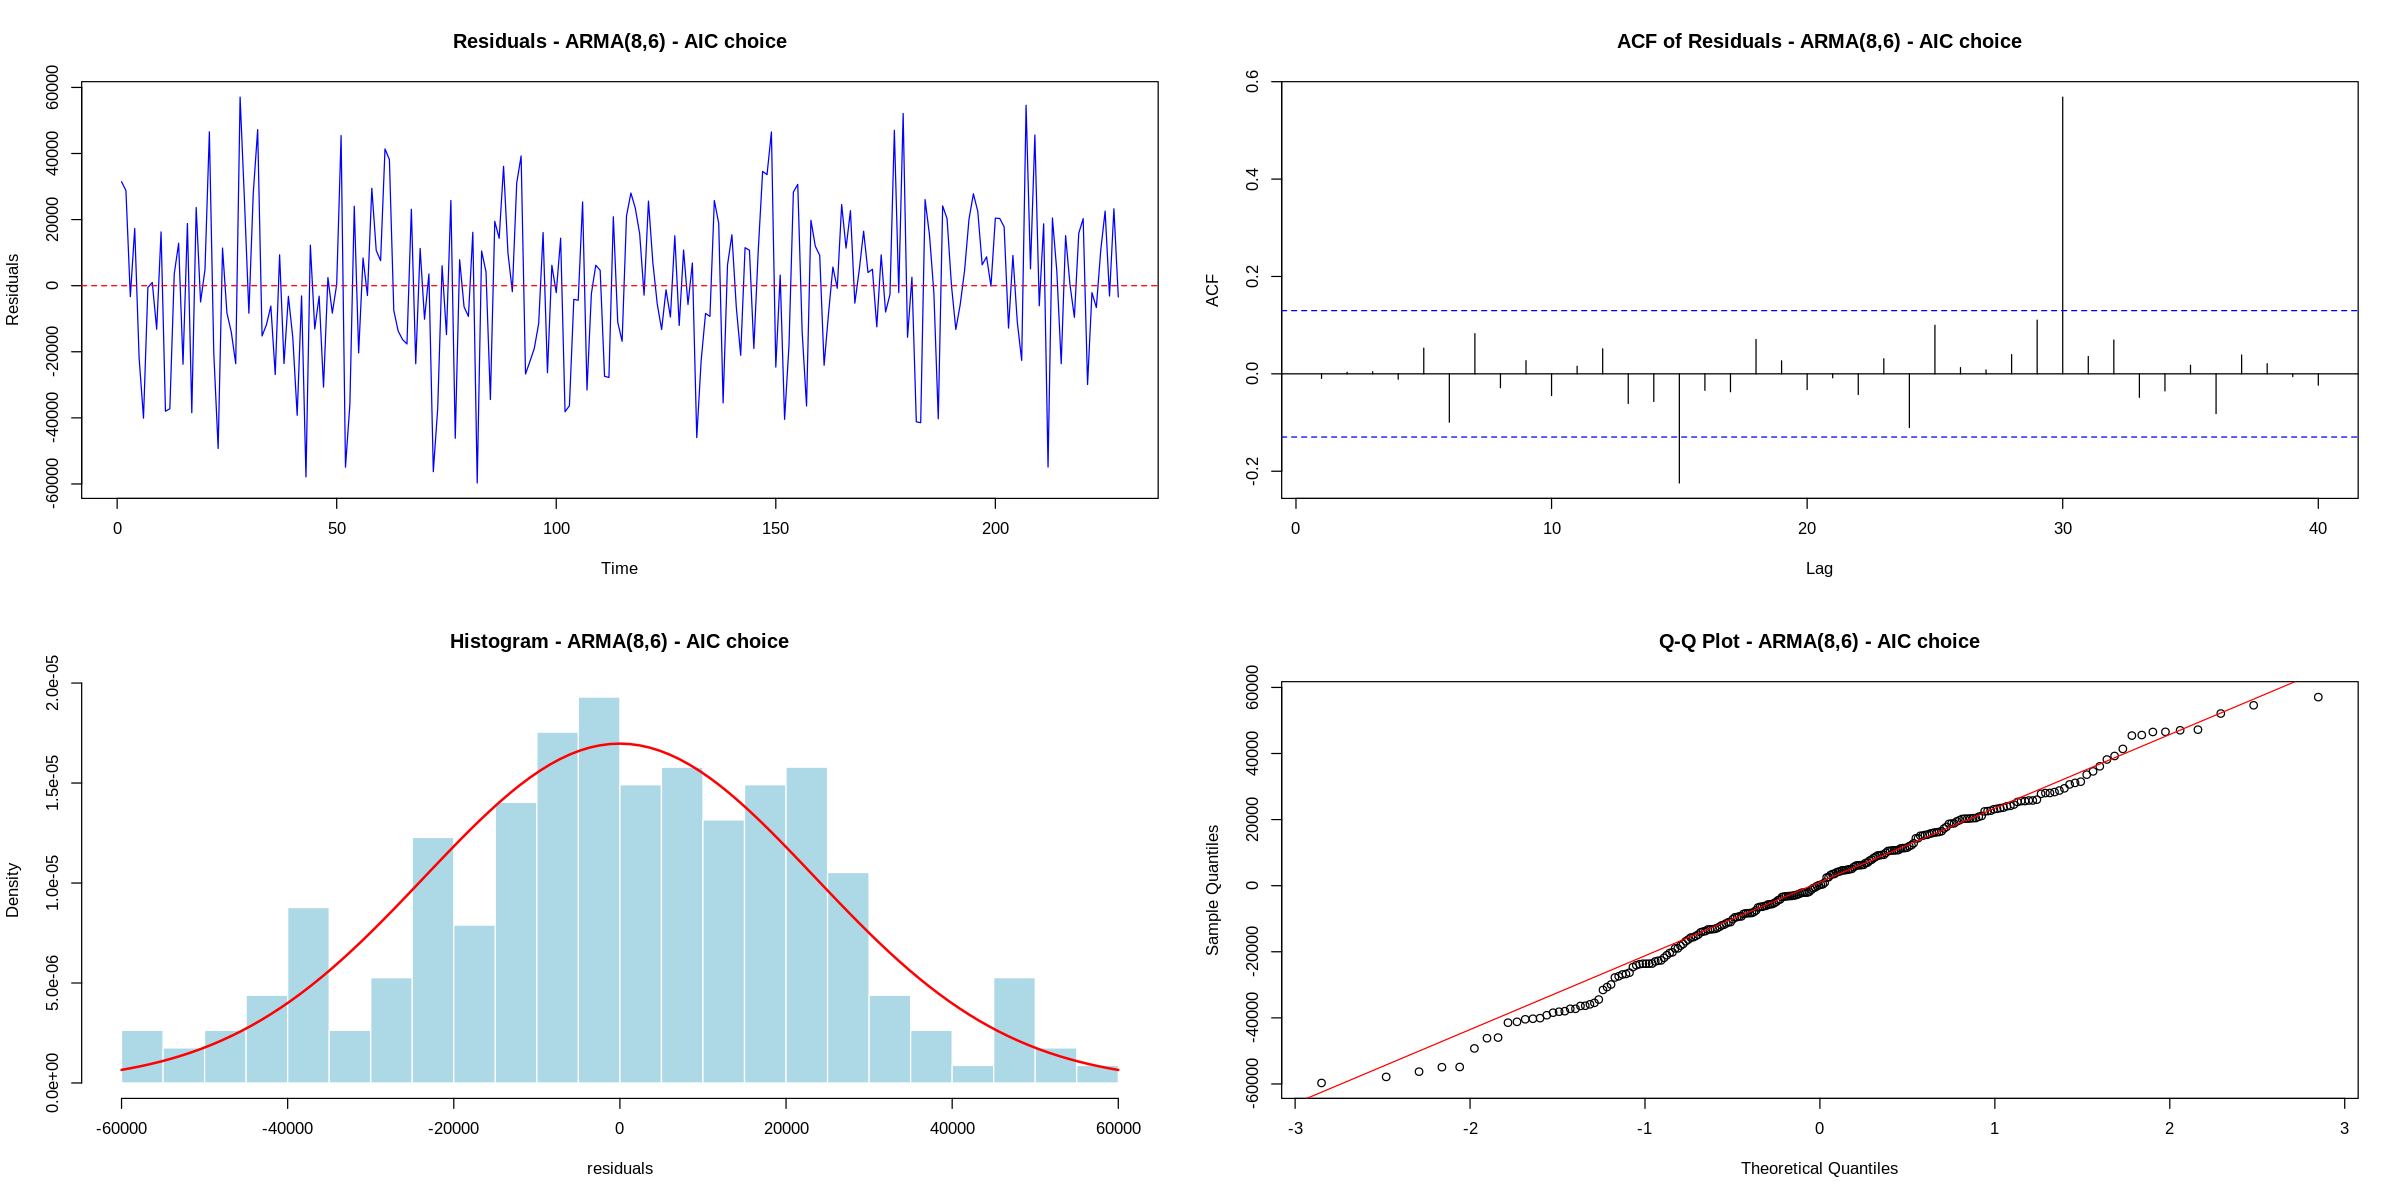

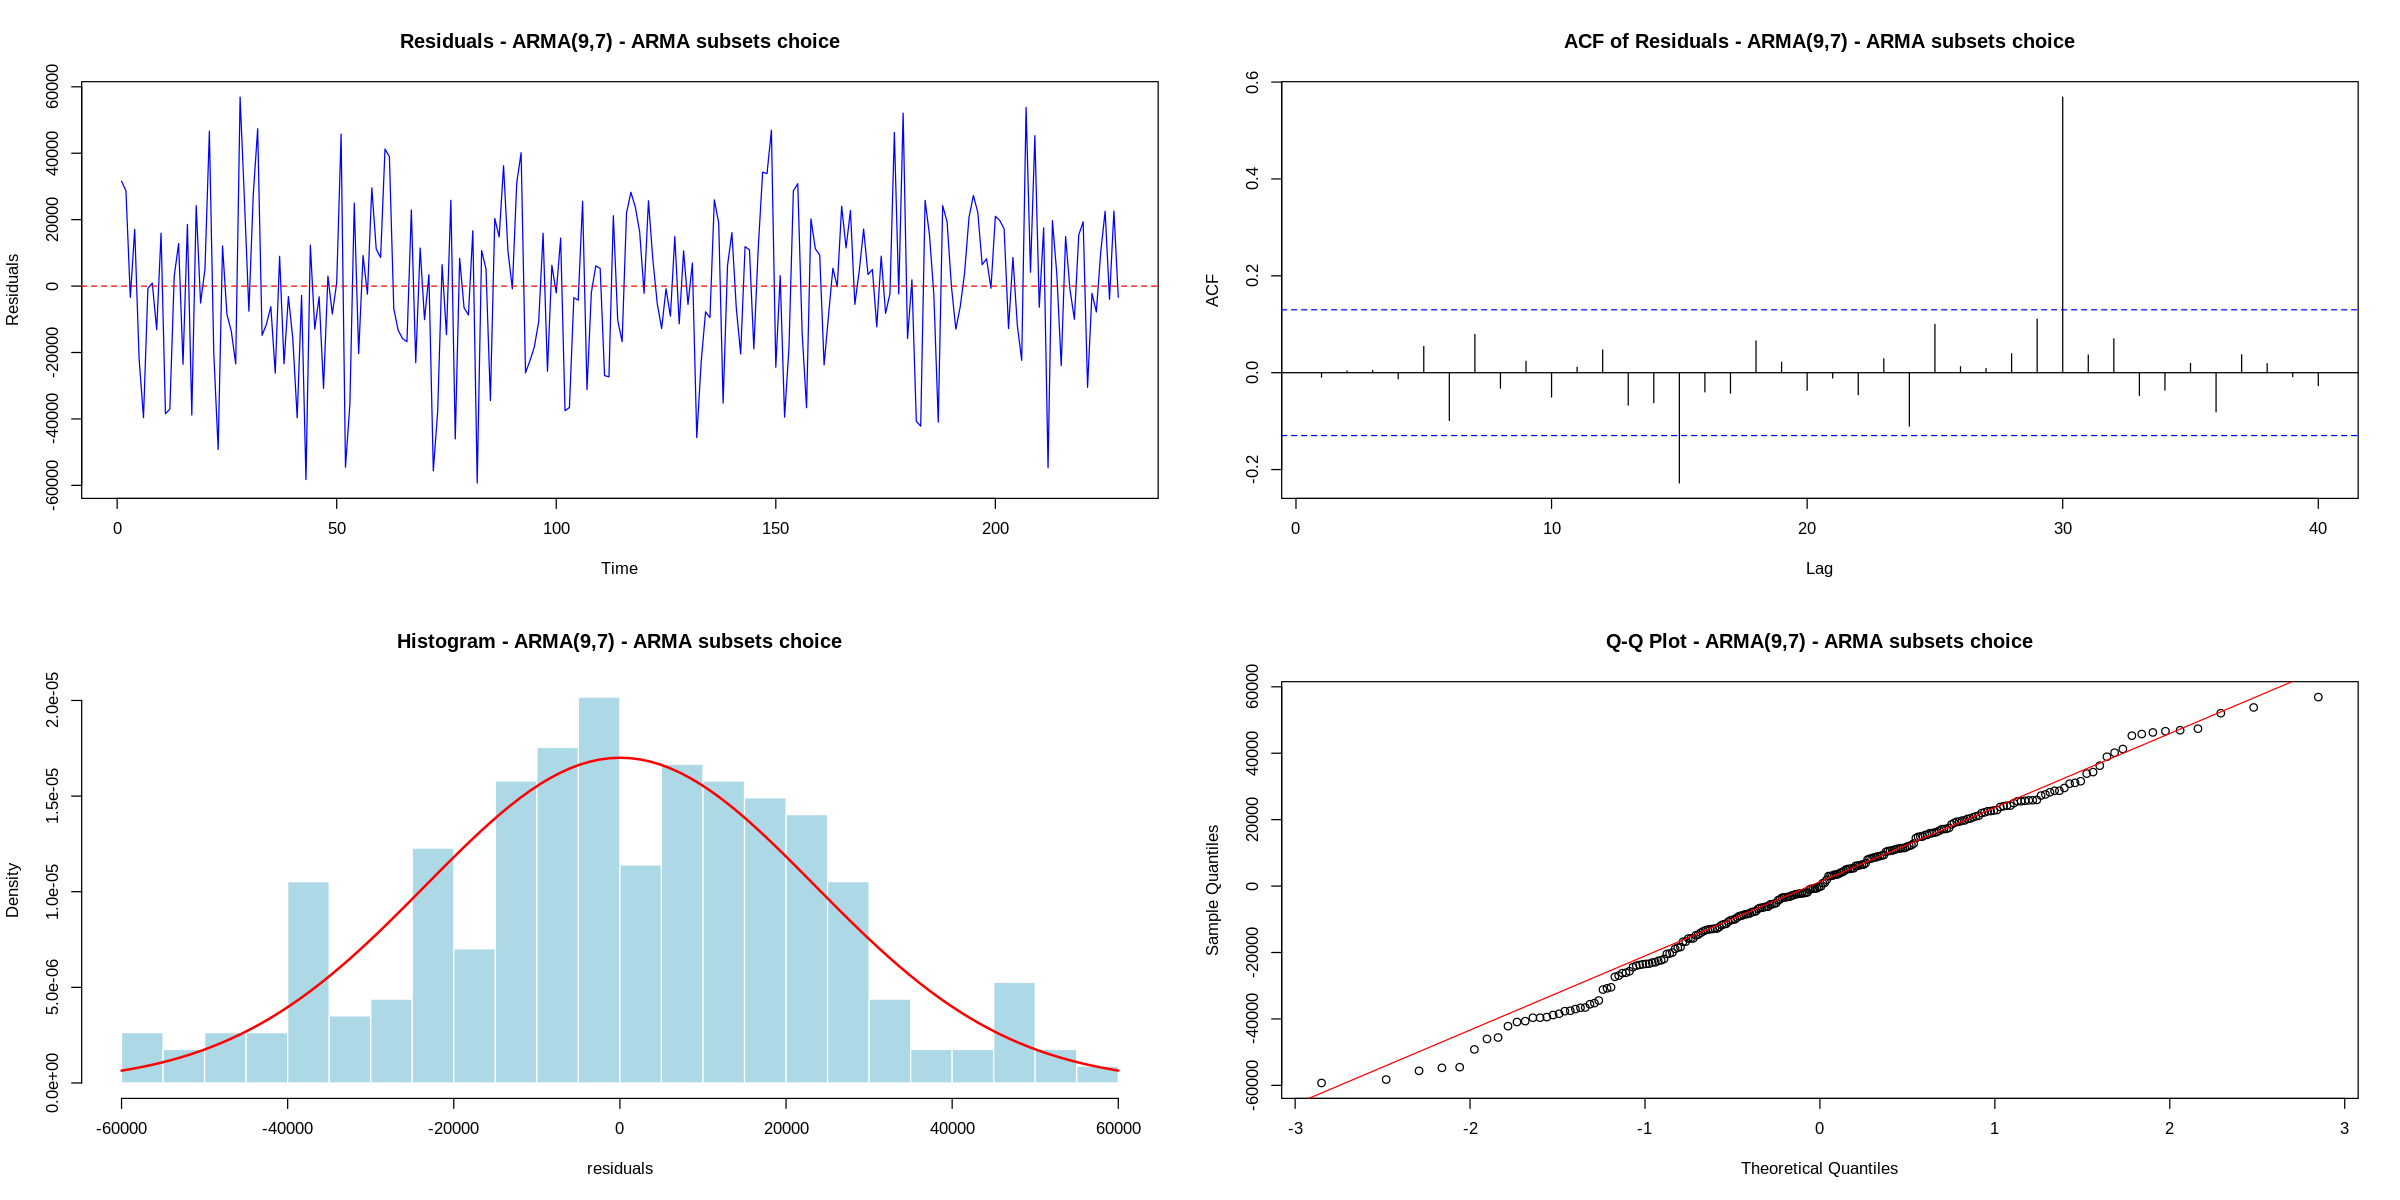

In [20]:
# Function to run comprehensive diagnostics on a model
run_diagnostics <- function(model, model_name) {
    cat("\n\n==== DIAGNOSTICS FOR", model_name, "====\n\n")

    # Extract residuals
    residuals <- residuals(model)

    # Ljung-Box test for autocorrelation in residuals
    lb_test <- Box.test(residuals, lag = 20, type = "Ljung-Box")
    cat("Ljung-Box test (lag=20):\n")
    cat("  Q =", round(lb_test$statistic, 4), ", p-value =", round(lb_test$p.value, 4), "\n")
    cat("  ", ifelse(lb_test$p.value > 0.05, "Fail to reject H0: Residuals are white noise", "Reject H0: Residuals have autocorrelation"), "\n\n")

    # Shapiro-Wilk test for normality
    sw_test <- shapiro.test(residuals)
    cat("Shapiro-Wilk normality test:\n")
    cat("  W =", round(sw_test$statistic, 4), ", p-value =", round(sw_test$p.value, 4), "\n")
    cat("  ", ifelse(sw_test$p.value > 0.05, "Fail to reject H0: Residuals are normal", "Reject H0: Residuals are not normal"), "\n\n")

    # ARCH test for heteroskedasticity
    arch_test <- ArchTest(residuals, lags = 12)
    cat("ARCH test (lag=12):\n")
    cat("  Chi-square =", round(arch_test$statistic, 4), ", p-value =", round(arch_test$p.value, 4), "\n")
    cat("  ", ifelse(arch_test$p.value > 0.05, "Fail to reject H0: No ARCH effects", "Reject H0: ARCH effects present"), "\n\n")

    # Runs test for randomness
    runs_test <- runs.test(residuals)
    cat("Runs test:\n")
    cat("  Z =", round(runs_test$statistic, 4), ", p-value =", round(runs_test$p.value, 4), "\n")
    cat("  ", ifelse(runs_test$p.value > 0.05, "Fail to reject H0: Residuals are random", "Reject H0: Residuals are not random"), "\n\n")

    # Plot diagnostics
    par(mfrow=c(2,2), bg="white")

    # Plot 1: Residuals over time
    plot(residuals, type="l", main=paste("Residuals -", model_name),
             col="blue", ylab="Residuals")
    abline(h=0, col="red", lty=2)

    # Plot 2: ACF of residuals
    acf(residuals, main=paste("ACF of Residuals -", model_name), lag.max=40)

    # Plot 3: Histogram of residuals with normal curve
    hist(residuals, breaks=20, main=paste("Histogram -", model_name),
             probability=TRUE, col="lightblue", border="white")
    curve(dnorm(x, mean=mean(residuals), sd=sd(residuals)),
                add=TRUE, col="red", lwd=2)

    # Plot 4: QQ plot
    qqnorm(residuals, main=paste("Q-Q Plot -", model_name))
    qqline(residuals, col="red")

    par(mfrow=c(1,1))
}

# Run diagnostics on each model
run_diagnostics(model_bic, "ARMA(2,1) - BIC choice")
run_diagnostics(model_aic, "ARMA(8,6) - AIC choice")
run_diagnostics(model_armasub, "ARMA(9,7) - ARMA subsets choice")

# Diagnostic Test Comparison for ARIMA Models

| Test | Statistic | ARMA(2,1) - BIC Choice | ARMA(8,6) - AIC Choice | ARMA(9,7) - ARMA Subsets |
|------|-----------|------------------------|------------------------|--------------------------|
| **Ljung-Box** (lag=20) | Q | 40.6587 | 22.557 | 23.2103 |
|  | p-value | 0.0041 | 0.3111 | 0.2786 |
|  | Result | ❌ Reject H₀ (Has autocorrelation) | ✅ Fail to reject H₀ (White noise) | ✅ Fail to reject H₀ (White noise) |
| **Shapiro-Wilk** | W | 0.9897 | 0.9924 | 0.9923 |
|  | p-value | 0.1058 | 0.2861 | 0.2748 |
|  | Result | ✅ Fail to reject H₀ (Normal) | ✅ Fail to reject H₀ (Normal) | ✅ Fail to reject H₀ (Normal) |
| **ARCH** (lag=12) | Chi-square | 14.555 | 17.7584 | 17.72 |
|  | p-value | 0.2667 | 0.1232 | 0.1245 |
|  | Result | ✅ Fail to reject H₀ (No ARCH effects) | ✅ Fail to reject H₀ (No ARCH effects) | ✅ Fail to reject H₀ (No ARCH effects) |
| **Runs** | Z | 0 | 1.9912 | 1.9912 |
|  | p-value | 1 | 0.0465 | 0.0465 |
|  | Result | ✅ Fail to reject H₀ (Random) | ❌ Reject H₀ (Not random) | ❌ Reject H₀ (Not random) |

## Summary of Diagnostics

- **ARMA(2,1)**: Fails Ljung-Box test (has autocorrelation in residuals), but passes tests for normality, no ARCH effects, and randomness.
- **ARMA(8,6)**: Passes Ljung-Box test (no autocorrelation), normality test, and ARCH test, but fails the runs test (suggesting non-random pattern in residuals).
- **ARMA(9,7)**: Similar to ARMA(8,6) - passes Ljung-Box test, normality test, and ARCH test, but fails the runs test.

None of the models passes all diagnostic tests, we can see the trade-off between the Ljung-Box test and the Runs test, but overall, ARMA(8,6) and ARMA(9,7) perform similarly and better than ARMA(2,1) in terms of residual autocorrelation.

## **Phase III: Application**

We will use the three models for forcating and then compare them. Since we applied a **quadratic transformation**, the corresponding **Minimum Mean Squared Error (MMSE) forecast** of \( Y_{t+l} \) is given by:

$$
\tilde{Y}_t (l) = \left( \tilde{Z}_t (l) + \frac{1}{2} \text{Var}[e_t(l)] \right)^2
$$
where $\text{Var}[e_t(l)]$ is the variance of the l-step ahead forecast error


$$
e_t(l) = Z_{t+l} - \tilde{Z}_t(l).
$$

This follows from the inverse transformation for the quadratic case, ensuring an unbiased forecast adjustment by incorporating the variance correction term.



Table: Forecast Accuracy Comparison

|Model     |    MAE|   RMSE|  MAPE|
|:---------|------:|------:|-----:|
|ARMA(2,1) | 160.53| 168.31| 25.68|
|ARMA(8,6) | 163.68| 168.91| 26.38|
|ARMA(9,7) | 162.92| 168.17| 26.25|


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


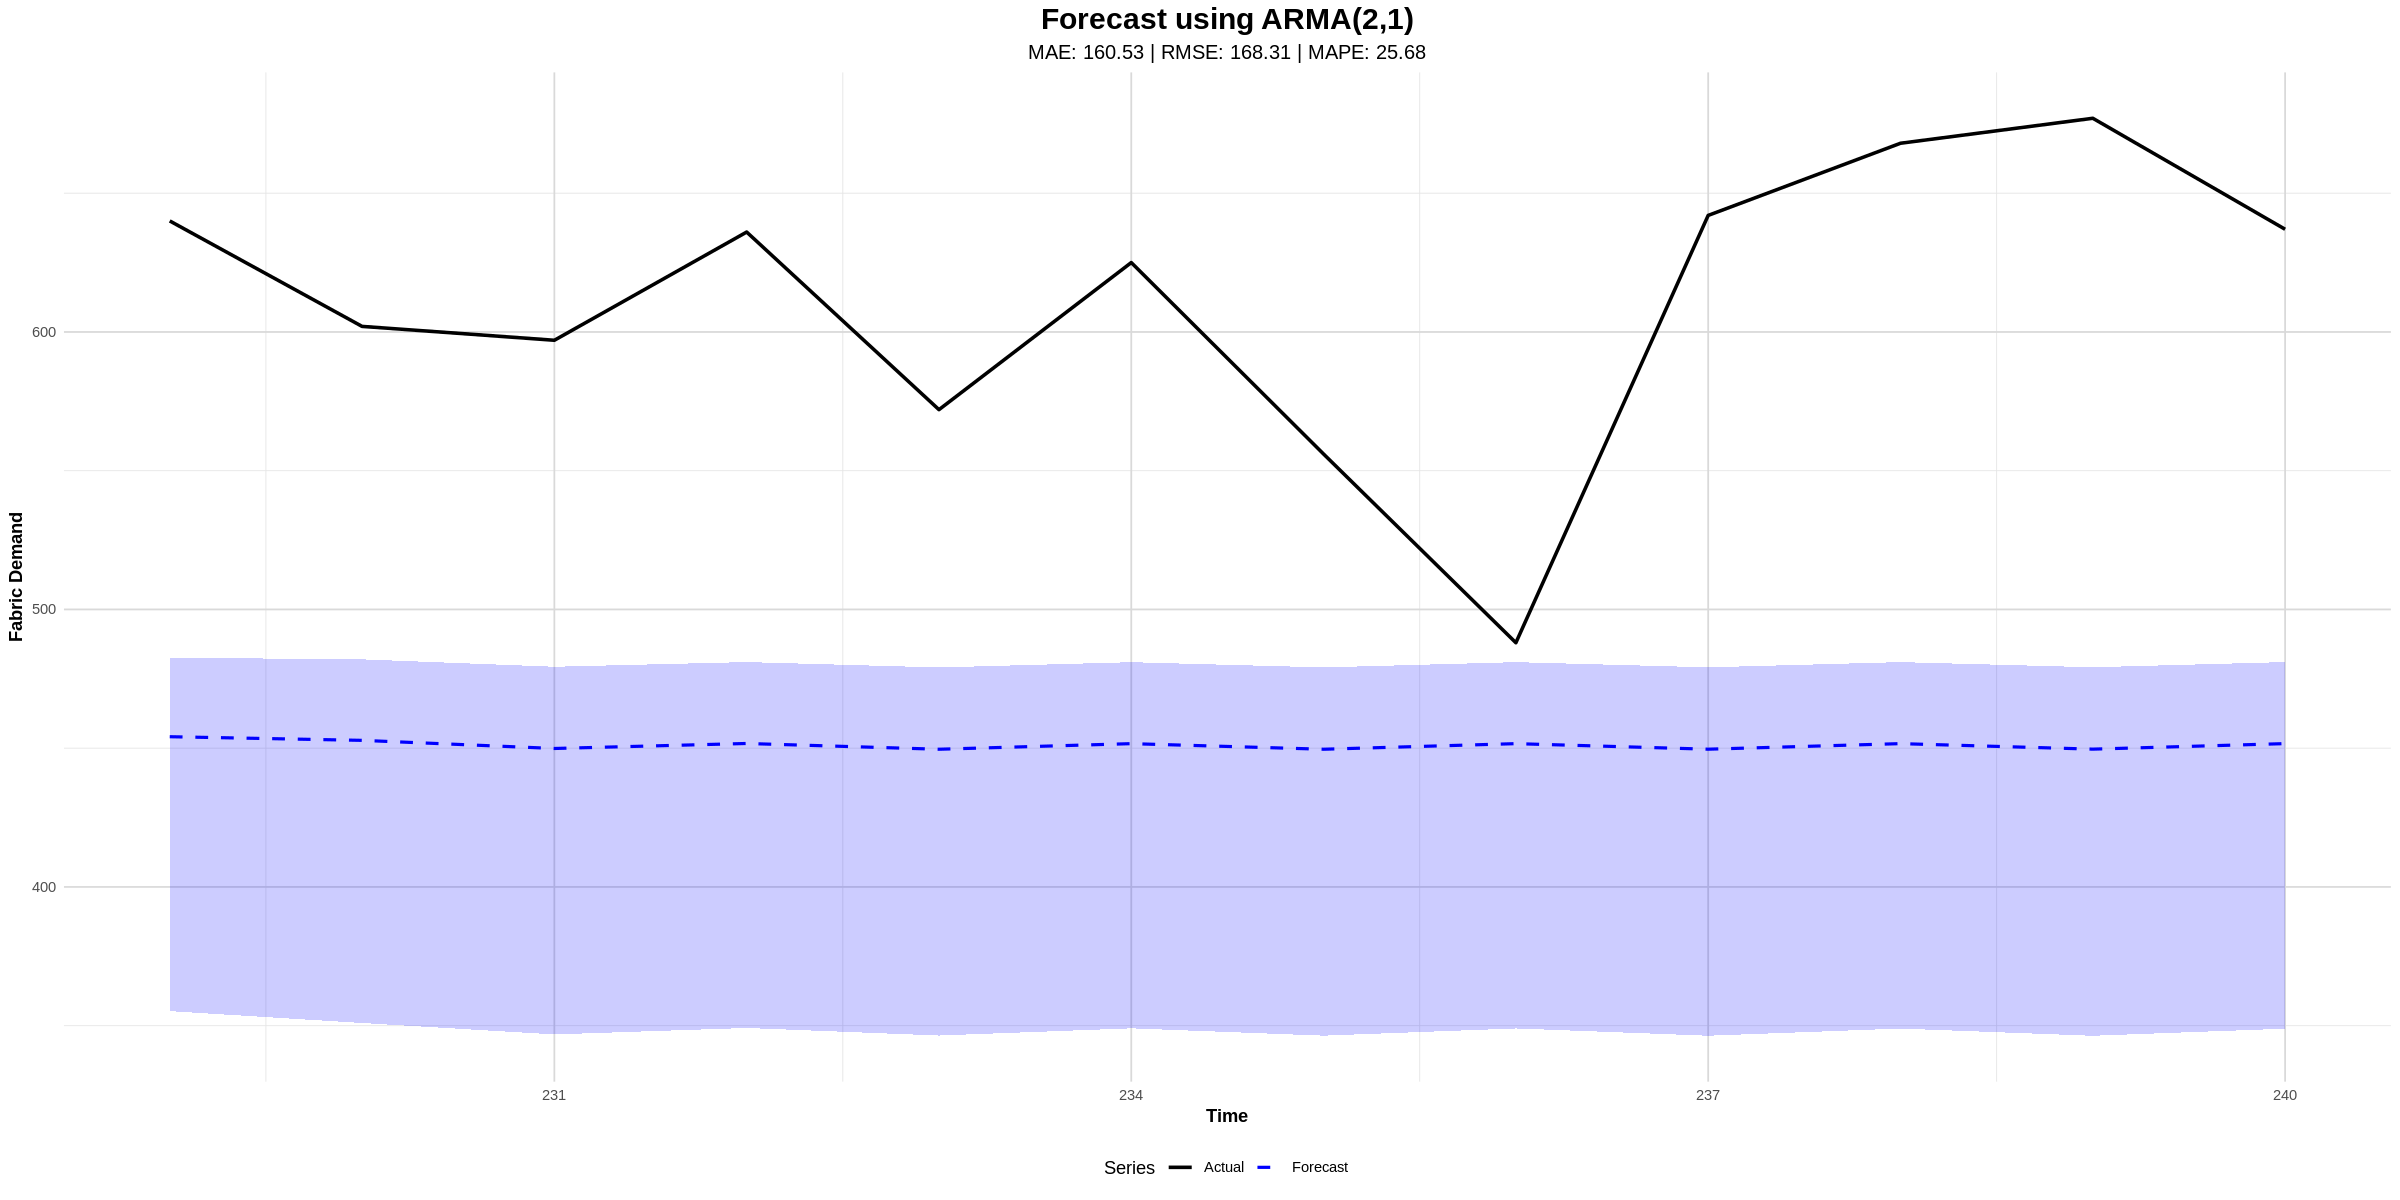

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


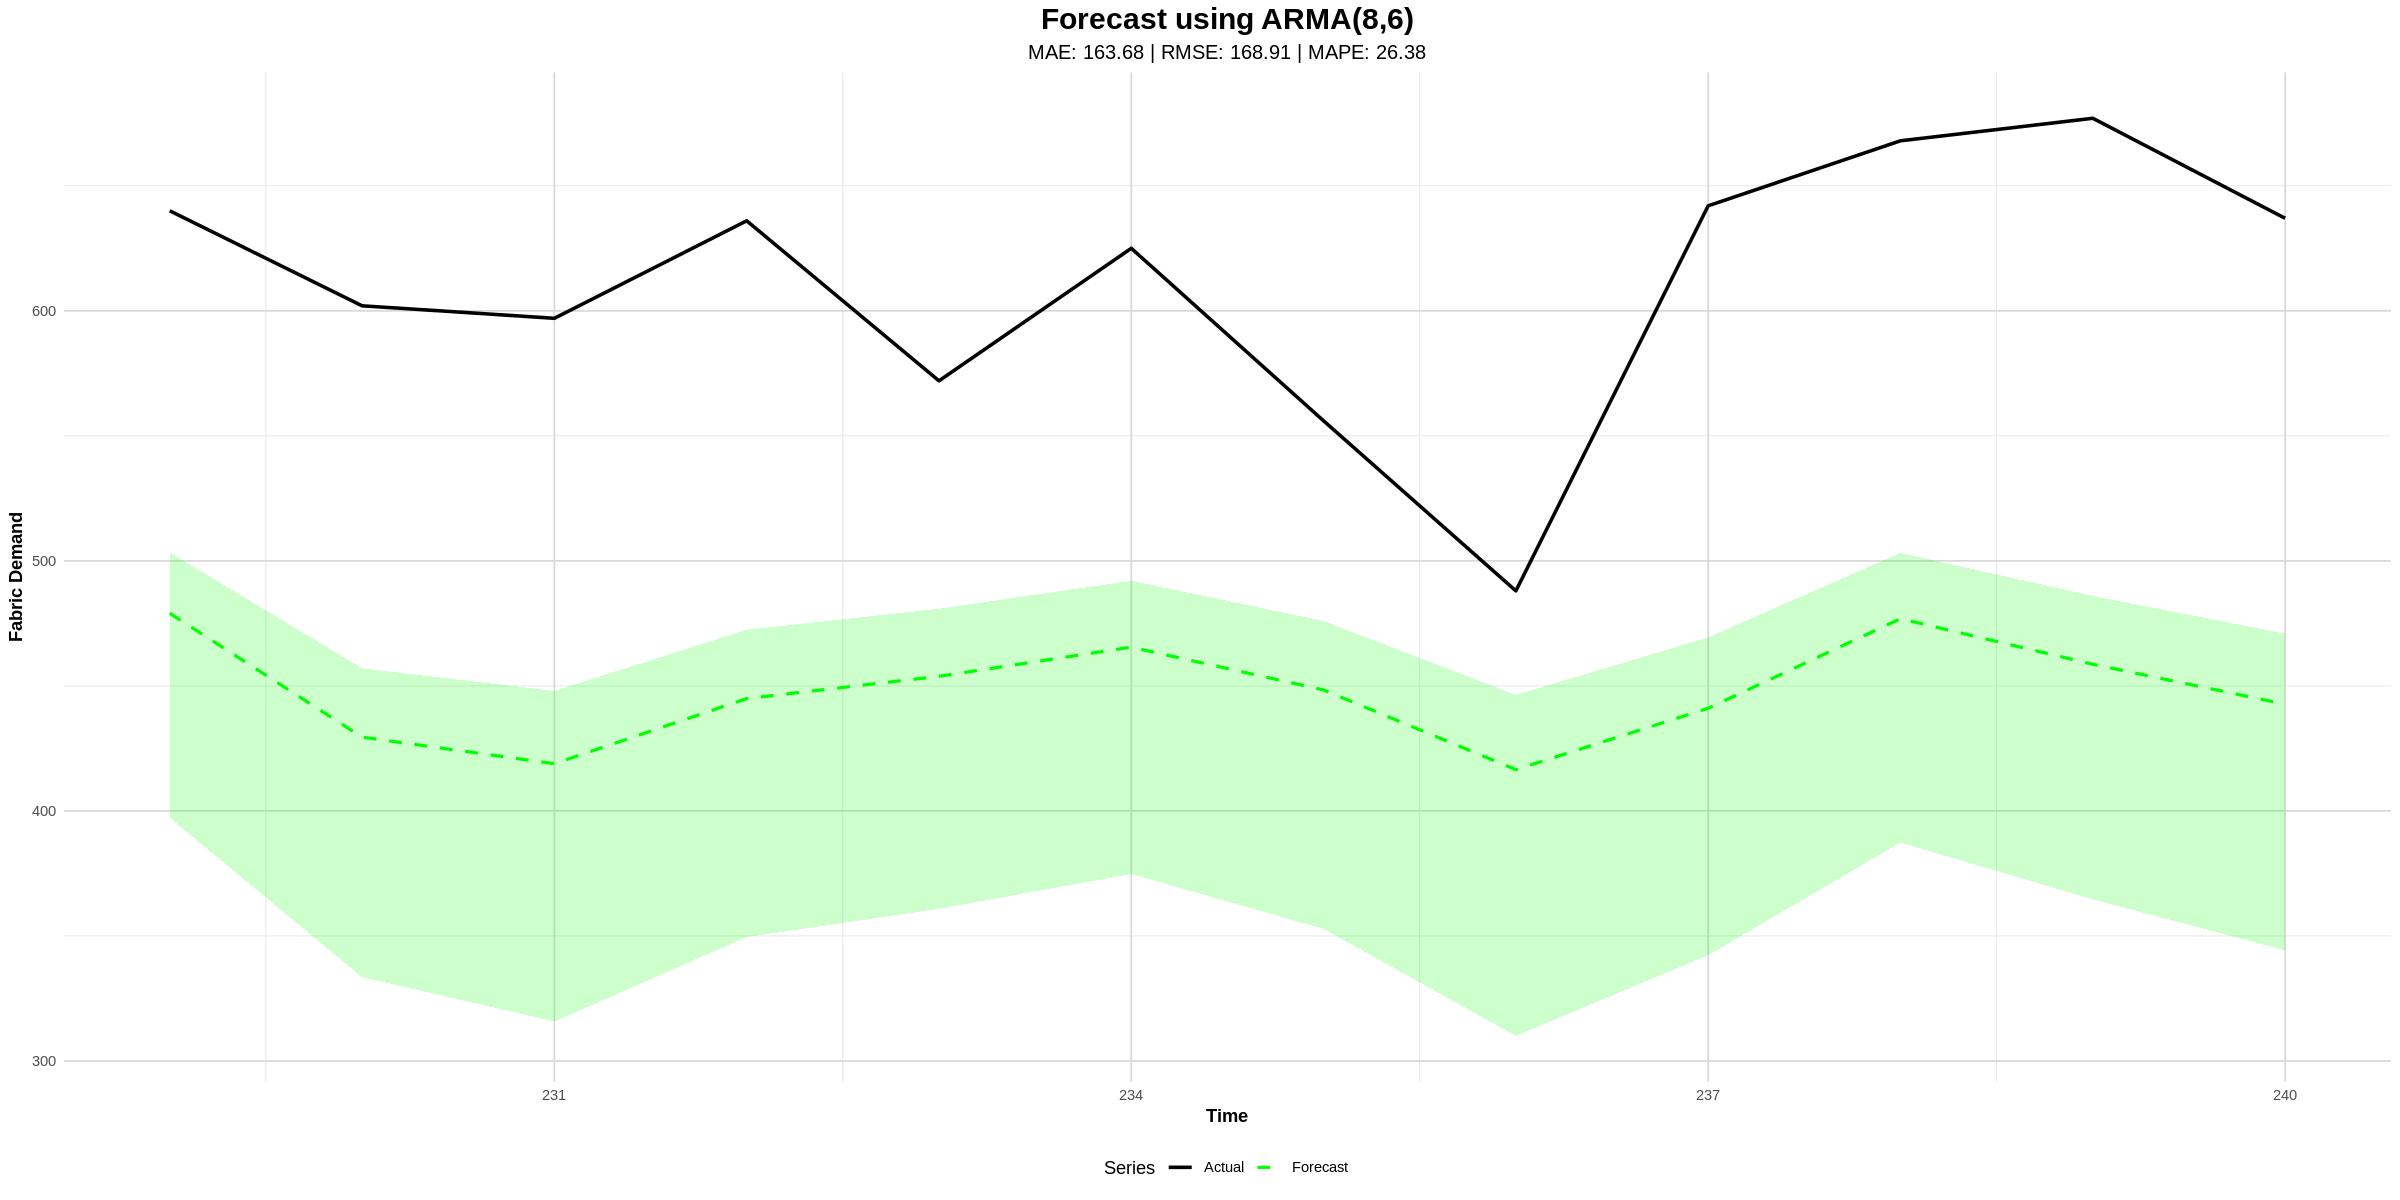

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


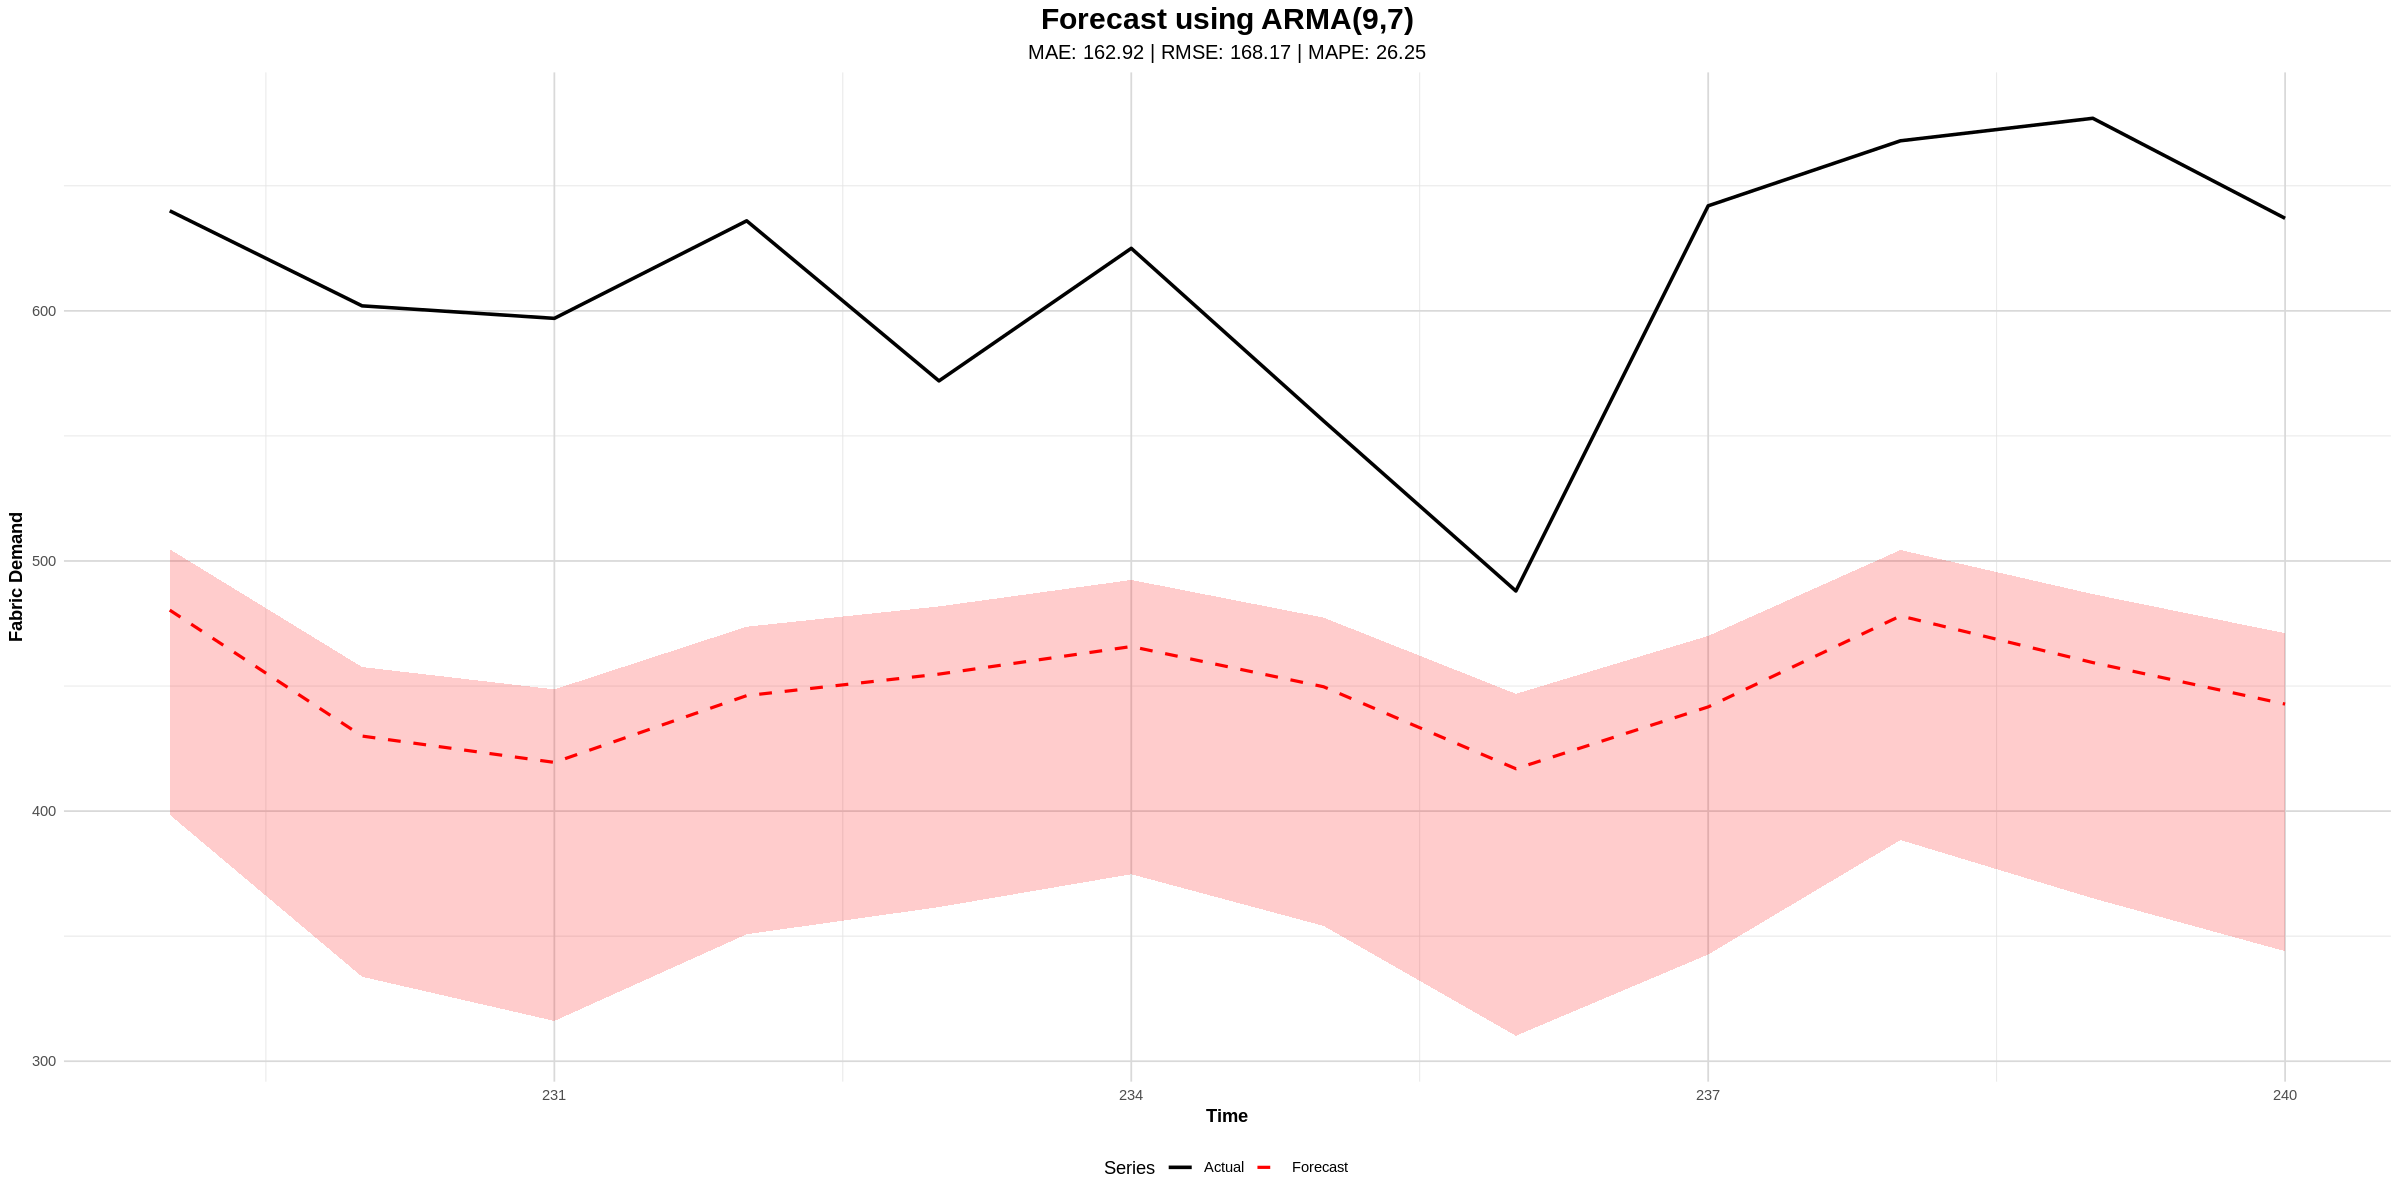

TableGrob (4 x 1) "arrange": 4 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (3-3,1-1) arrange      gtable[layout]
3 3 (4-4,1-1) arrange      gtable[layout]
4 4 (1-1,1-1) arrange text[GRID.text.522]


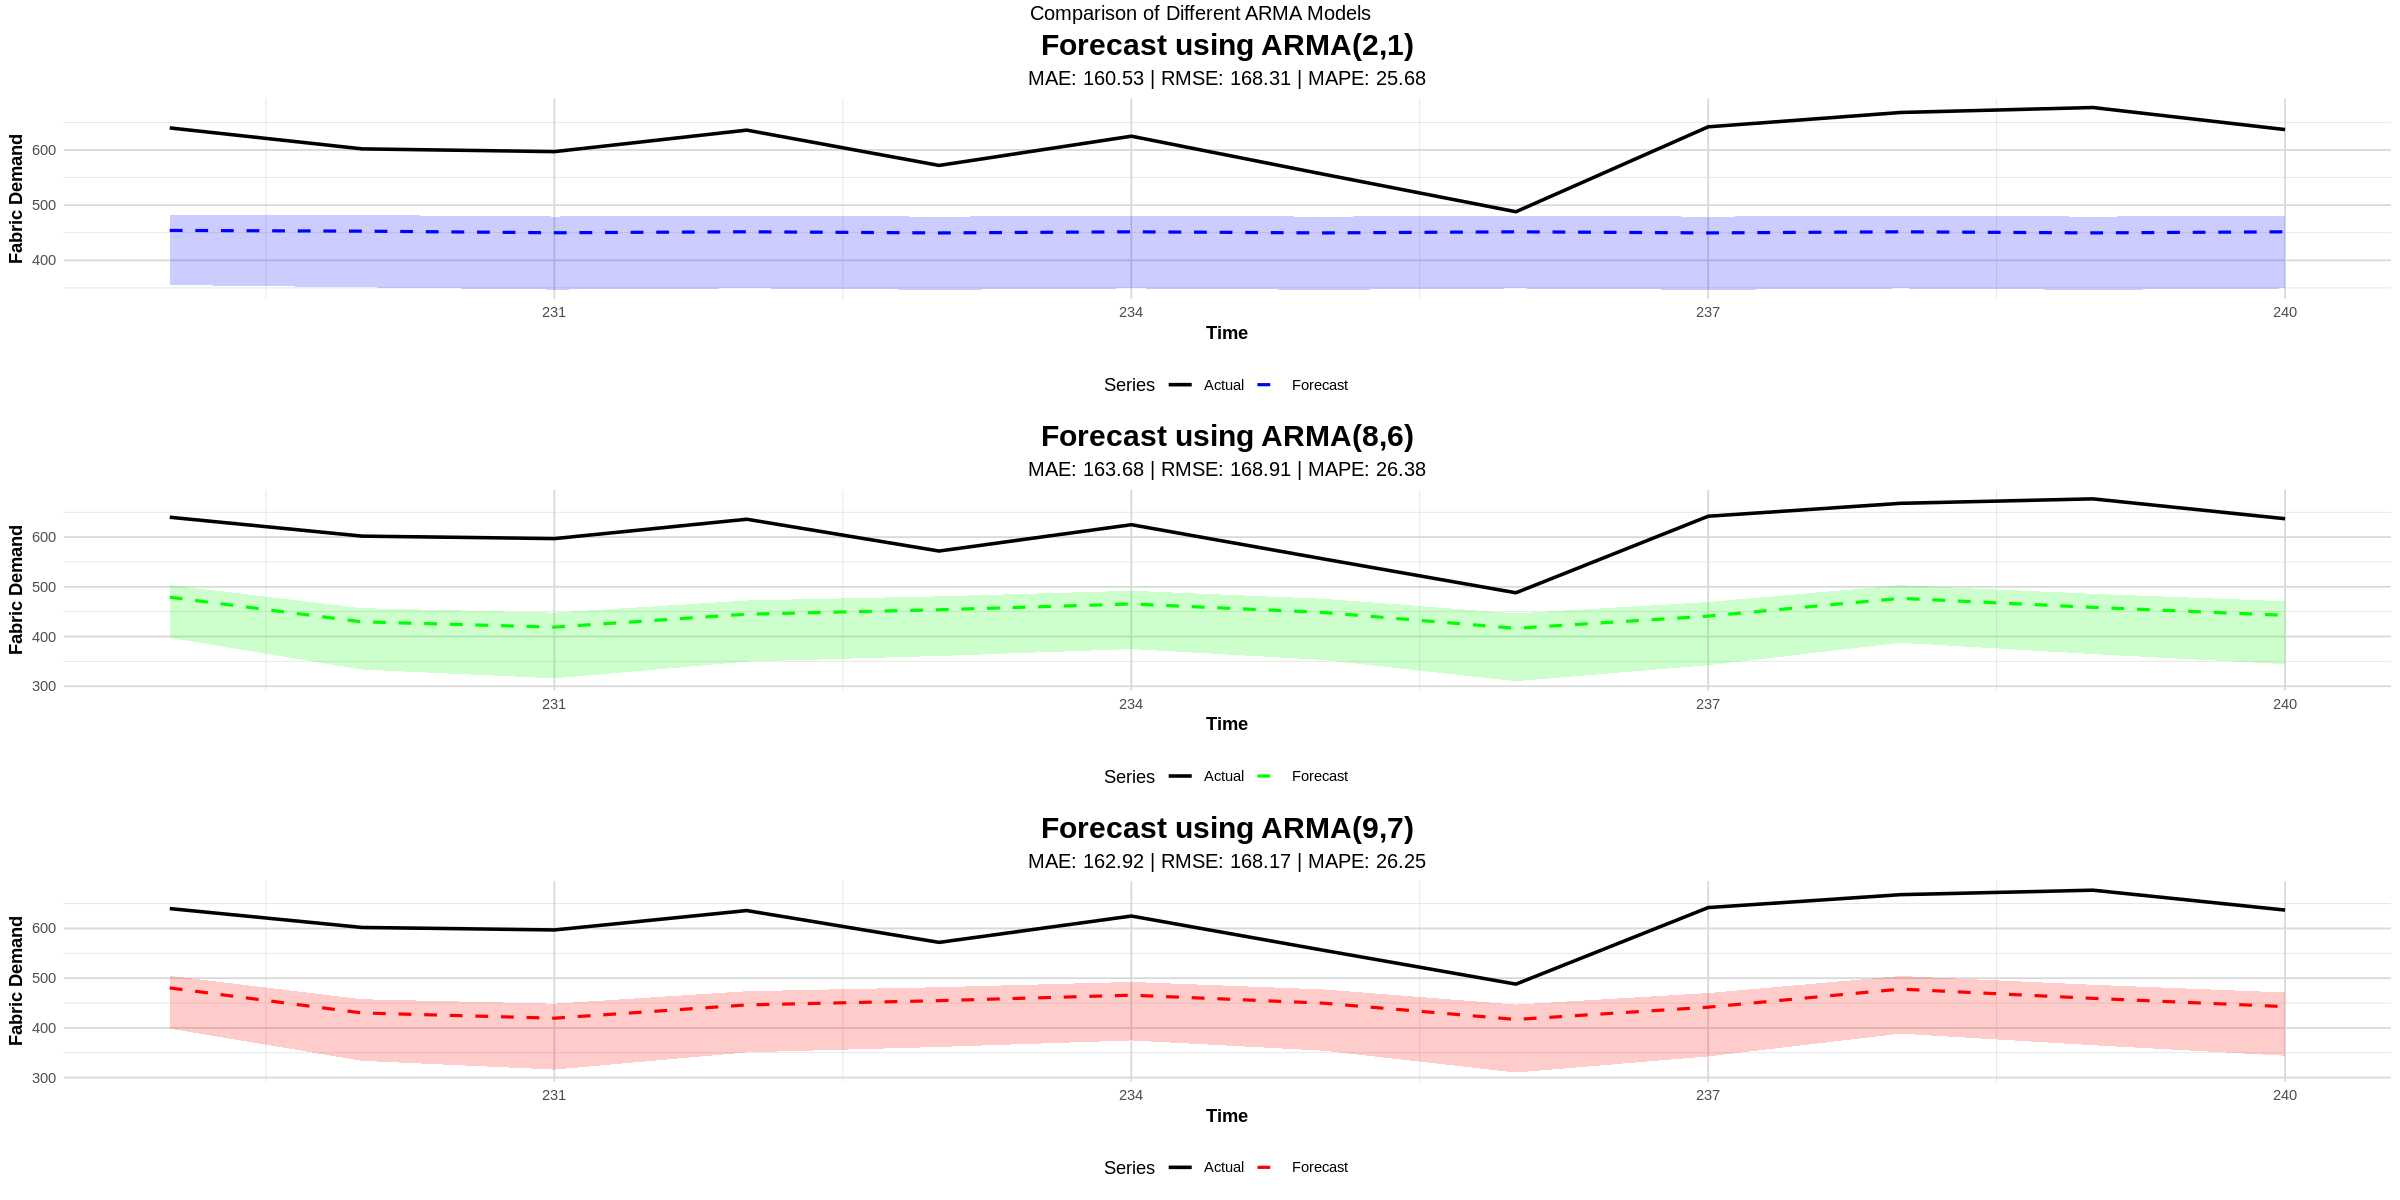

In [21]:
# Create forecasts with each model
h <- length(test)  # Number of periods to forecast
forecast_bic <- forecast(model_bic, h=h)
forecast_aic <- forecast(model_aic, h=h)
forecast_armasub <- forecast(model_armasub, h=h)

# Apply inverse transformation (with bias correction)
# For quadratic transformation (λ=2), Y = Z^(1/λ) = sqrt(Z)

# Function to apply inverse transformation with bias correction
inverse_transform <- function(fc, lambda=2) {
    # Point forecasts with bias correction
    mean_forecast <- fc$mean
    var_forecast <- fc$upper[,2] - fc$mean  # Approximate variance from prediction intervals

    # Apply bias correction formula: (mean + variance/2)^(1/λ)
    point_forecast_adjusted <- (mean_forecast + var_forecast/2)^(1/lambda)

    # Transform prediction intervals
    lower <- fc$lower^(1/lambda)
    upper <- fc$upper^(1/lambda)

    return(list(mean=point_forecast_adjusted, lower=lower, upper=upper))
}

# Apply inverse transformations
inv_forecast_bic <- inverse_transform(forecast_bic)
inv_forecast_aic <- inverse_transform(forecast_aic)
inv_forecast_armasub <- inverse_transform(forecast_armasub)

# Calculate forecast accuracy metrics
calculate_metrics <- function(actual, forecast) {
    mae <- mean(abs(actual - forecast))
    rmse <- sqrt(mean((actual - forecast)^2))
    mape <- mean(abs((actual - forecast)/actual)) * 100
    return(c(MAE=mae, RMSE=rmse, MAPE=mape))
}

metrics_bic <- calculate_metrics(test, inv_forecast_bic$mean)
metrics_aic <- calculate_metrics(test, inv_forecast_aic$mean)
metrics_armasub <- calculate_metrics(test, inv_forecast_armasub$mean)

# Combine metrics into a dataframe
metrics_df <- data.frame(
    Model = c("ARMA(2,1)", "ARMA(8,6)", "ARMA(9,7)"),
    MAE = c(metrics_bic[1], metrics_aic[1], metrics_armasub[1]),
    RMSE = c(metrics_bic[2], metrics_aic[2], metrics_armasub[2]),
    MAPE = c(metrics_bic[3], metrics_aic[3], metrics_armasub[3])
)

# Display metrics table
print(kable(metrics_df, caption = "Forecast Accuracy Comparison", digits = 2))

# Create individual plots for each model
# First, prepare the base dataframe with time and actual values
base_df <- data.frame(
    Time = test_df$week,
    Actual = test
)

# Function to create a forecast plot for a single model
create_forecast_plot <- function(actual_df, forecast_values, lower_values, upper_values,
                                model_name, model_color) {
    # Create dataframe for this model
    model_df <- actual_df
    model_df$Forecast <- forecast_values
    model_df$Lower <- lower_values[,2]  # 95% confidence interval
    model_df$Upper <- upper_values[,2]

    # Create the plot
    p <- ggplot(model_df, aes(x = Time)) +
        # Add prediction interval ribbon
        geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = model_color, alpha = 0.2) +
        # Add actual values line
        geom_line(aes(y = Actual, color = "Actual"), size = 1) +
        # Add forecast line
        geom_line(aes(y = Forecast, color = "Forecast"), linetype = "dashed", size = 0.9) +
        # Add labels
        labs(
            title = paste("Forecast using", model_name),
            subtitle = paste("MAE:", round(metrics_df$MAE[metrics_df$Model == model_name], 2),
                           "| RMSE:", round(metrics_df$RMSE[metrics_df$Model == model_name], 2),
                           "| MAPE:", round(metrics_df$MAPE[metrics_df$Model == model_name], 2)),
            x = "Time",
            y = "Fabric Demand",
            color = "Series"
        ) +
        scale_color_manual(
            values = c("Actual" = "black", "Forecast" = model_color)
        ) +
        theme_tsa() +
        theme(legend.position = "bottom")

    return(p)
}

# Create individual plots
p_bic <- create_forecast_plot(
    base_df,
    inv_forecast_bic$mean,
    inv_forecast_bic$lower,
    inv_forecast_bic$upper,
    "ARMA(2,1)",
    "blue"
)

p_aic <- create_forecast_plot(
    base_df,
    inv_forecast_aic$mean,
    inv_forecast_aic$lower,
    inv_forecast_aic$upper,
    "ARMA(8,6)",
    "green"
)

p_armasub <- create_forecast_plot(
    base_df,
    inv_forecast_armasub$mean,
    inv_forecast_armasub$lower,
    inv_forecast_armasub$upper,
    "ARMA(9,7)",
    "red"
)

# Print individual plots
print(p_bic)
print(p_aic)
print(p_armasub)

# If you want to arrange them in a grid (optional)
if (require("gridExtra")) {
    grid_plot <- gridExtra::grid.arrange(
        p_bic, p_aic, p_armasub,
        ncol = 1,
        top = "Comparison of Different ARMA Models"
    )
    print(grid_plot)
}

# Final Analysis

## Forecast Accuracy Comparison

| Model     | MAE    | RMSE   | MAPE  |
|:----------|-------:|-------:|------:|
| ARMA(2,1) | 160.53 | 168.31 | 25.68 |
| ARMA(8,6) | 163.68 | 168.91 | 26.38 |
| ARMA(9,7) | 162.92 | 168.17 | 26.25 |

## Key Findings and Analysis

1. **Parsimony Principle Validated**: Despite its simplicity, the ARMA(2,1) model outperformed more complex models in forecasting accuracy. This confirms the statistical principle that simpler models often generalize better to new data.

2. **In-Sample vs. Out-of-Sample Performance Trade-off**: The ARMA(8,6) model had the best fit on training data (lowest AIC) but performed worst on test data. This highlights the classic bias-variance trade-off in statistical modeling.

3. **Diagnostic Tests vs. Forecast Performance**: Interestingly, the ARMA(2,1) model failed the Ljung-Box test (indicating residual autocorrelation) yet produced the most accurate forecasts. This suggests that passing all diagnostic tests doesn't guarantee superior forecasting performance.

4. **Forecasting Error Magnitudes**: All models show relatively high MAPE values (25-26%), indicating that the forecasts are, on average, off by about a quarter of the true demand value. This gives a good approximation of the extra margine to be considered when estimating the demand.

5. **Model Complexity vs. Stability**: While more complex models can capture additional patterns in training data, they may also be fitting to noise. The parameter estimation issues in the ARMA(9,7) model (NaN standard errors) indicate potential overfitting or identification problems.

## Limitations of the Study

1. **Model Specification Limitations**:
   - The Box-Cox transformation with λ≈2 was used, but other transformations might provide better stabilization of variance.

2. **Data Limitations**:
   - Limited sample size may affect the reliability of parameter estimates, especially for complex models.
   - Possible presence of outliers or structural breaks not specifically addressed in the modeling process.

3. **Methodological Limitations**:
   - Fixed train-test split might not be optimal; a rolling-window approach could provide more robust evaluation.
   - Model selection focused on AIC/BIC metrics, which might not align perfectly with forecasting objectives.
   - Diagnostic tests have limited power with finite samples, potentially missing some model inadequacies.

4. **Practical Implementation Challenges**:
   - High MAPE values (25-26%) indicate substantial forecast uncertainty, which may limit practical usefulness.
   - No consideration of the asymmetric costs of over-forecasting versus under-forecasting in the fabric industry.
   - The models do not account for potential lead time in production planning or inventory considerations.

5. **Statistical Assumptions**:
   - ARIMA models assume linear relationships and constant parameters over time.
   - The models assume that past patterns will continue into the future, which may not hold during market disruptions.

## Conclusion and Recommendations

**Best Overall Model**: The ARMA(2,1) model offers the best balance between simplicity, interpretability, and forecast accuracy. Despite not perfectly modeling all autocorrelations in the residuals, it generalizes best to new data.

**Practical Implications**: For forecasting doubleknit fabric demand, the simpler ARMA(2,1) model is recommended for implementation. Its mathematical simplicity also makes it easier to interpret, update, and maintain in production.

**Forecasting Limitations**: The relatively high MAPE values across all models (25-26%) suggest fundamental limitations in using pure ARIMA models for this data. This level of error should be factored into inventory planning and decision-making.

**Future Directions**:
1. Consider hybrid or ensemble models combining multiple forecasting methods
2. Explore incorporating external variables (such as economic indicators or seasonal factors)
3. Investigate whether the data exhibits nonlinear patterns that linear ARIMA models cannot capture
4. Implement a rolling-horizon forecasting approach to continually update and evaluate model performance

This study reinforces an important lesson in time series forecasting: the best-fitting model on historical data isn't necessarily the best for predicting future values. For practical forecasting tasks, simpler models with good predictive performance are often preferable to complex models that fit historical data extremely well but generalize poorly.